# Importaciones

In [5]:
!pip install -q evaluate transformers datasets seaborn nltk spacy torch chardet umap wordcloud scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.5 MB/s eta 0:00:00
   

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import nltk, re, spacy
import torch, os, zipfile, chardet, umap

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk import pos_tag
from evaluate import load
from torch.utils.data import Dataset
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import jensenshannon
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

Usando: cuda


# Dataset cargado limpiado

In [7]:
# Descomprimir el archivo zip
def unzip_data(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip_data("bbc-train.zip", ".")
unzip_data("bbc-test.zip", ".")

In [8]:
# Cargar datos desde carpetas
def load_data(data_path):
    categories = ["business", "entertainment", "politics", "sports", "tech"]
    data = []

    def detect_encoding(file_path):
        with open(file_path, 'rb') as f:
            result = chardet.detect(f.read())
        return result['encoding']

    for category in categories:
        folder_path = os.path.join(data_path, category)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            encoding = detect_encoding(file_path)
            with open(file_path, "r", encoding=encoding, errors="replace") as f:
                text = f.read()
                data.append((text, category))

    return pd.DataFrame(data, columns=["text", "category"])

# Cargar conjuntos de entrenamiento y test
df_train = load_data("bbc-train/")
df_test = load_data("bbc-test/")

# Preprocesamiento (Pipeline)

In [9]:
# Descargar recursos necesarios
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Cargar modelo de spaCy para lematización
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 4e6

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [10]:
example = df_train["text"].iloc[0]

## 1. Tokenización

In [11]:
# 1. Tokenización
tokens = word_tokenize(example.lower())  # Convertir a minúsculas y tokenizar
tokens[:9]

['retail',
 'sales',
 'show',
 'festive',
 'fervour',
 'uk',
 'retail',
 'sales',
 'were']

## 2. Estandarización

In [12]:
def standardize_tokens_spacy(tokens):
    text = " ".join(tokens)
    doc = nlp(text)

    standardized_tokens = [
        unicodedata.normalize("NFKD", token.text).encode("ASCII", "ignore").decode("utf-8")  # Eliminar acentos
        for token in doc
        if token.is_alpha
    ]

    return standardized_tokens

In [13]:
std_tokens = standardize_tokens_spacy(tokens)
print(std_tokens[:9])
print(f"Num tokens sin std: {len(tokens)}\nNum tokens con std: {len(std_tokens)}")

['retail', 'sales', 'show', 'festive', 'fervour', 'uk', 'retail', 'sales', 'were']
Num tokens sin std: 226
Num tokens con std: 193


## 3. Stop-words

In [14]:
stop_words = set(stopwords.words("english"))
stop_tokens = [token for token in std_tokens if token not in stop_words]
print(stop_tokens[:9])
print(f"Num tokens sin stop-words: {len(std_tokens)}\nNum tokens con stop-words: {len(stop_tokens)}")

['retail', 'sales', 'show', 'festive', 'fervour', 'uk', 'retail', 'sales', 'better']
Num tokens sin stop-words: 193
Num tokens con stop-words: 124


## 4. Stemming

In [15]:
stemmer = PorterStemmer()
stemmed_tokens = [stemmer.stem(token) for token in stop_tokens]
stemmed_tokens[:9]

['retail',
 'sale',
 'show',
 'festiv',
 'fervour',
 'uk',
 'retail',
 'sale',
 'better']

## 5. Lematización

In [16]:
lemmatized_tokens = [token.lemma_ for token in nlp(" ".join(stemmed_tokens))]
lemmatized_tokens[:9]

['retail', 'sale', 'show', 'festiv', 'fervour', 'uk', 'retail', 'sale', 'well']

## 6. Desambiguación

In [17]:
def get_wordnet_pos(word):
    """Mapea las etiquetas de POS de NLTK a las de WordNet."""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
disambiguated_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in lemmatized_tokens]
disambiguated_tokens[:9]

['retail', 'sale', 'show', 'festiv', 'fervour', 'uk', 'retail', 'sale', 'well']

## 7. Pipeline final

In [18]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = standardize_tokens_spacy(tokens)
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token.lemma_ for token in nlp(" ".join(tokens))]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    return tokens

In [19]:
df_train["processed"] = df_train["text"].apply(preprocess_text)
df_test["processed"] = df_test["text"].apply(preprocess_text)

In [20]:
print(df_train["processed"].iloc[0][:9])
df_train.head()

['retail', 'sale', 'show', 'festiv', 'fervour', 'uk', 'retail', 'sale', 'well']


text  category  \
0  Retail sales show festive fervour\n\nUK retail...  business   
1  Saudi investor picks up the Savoy\n\nLondon's ...  business   
2  Chinese exports rise 25% in 2004\n\nExports fr...  business   
3  GM, Ford cut output as sales fall\n\nUS car fi...  business   
4  UK 'risks breaking golden rule'\n\nThe UK gove...  business   

                                           processed  
0  [retail, sale, show, festiv, fervour, uk, reta...  
1  [saudi, investor, pick, savoy, london, famou, ...  
2  [chine, export, rise, export, china, leapt, pr...  
3  [gm, ford, cut, output, sale, fall, u, car, fi...  
4  [uk, risk, break, golden, rule, uk, govern, ra...

In [21]:
print(df_test["processed"].iloc[0][:9])
df_test.head()

['uk', 'coal', 'plung', 'deep', 'loss', 'share', 'uk', 'coal', 'fall']


text  category  \
0  UK Coal plunges into deeper loss\n\nShares in ...  business   
1  Electrolux to export Europe jobs\n\nElectrolux...  business   
2  Japanese mogul arrested for fraud\n\nOne of Ja...  business   
3  Hyundai to build new India plant\n\nSouth Kore...  business   
4  Boeing unveils new 777 aircraft\n\nUS aircraft...  business   

                                           processed  
0  [uk, coal, plung, deep, loss, share, uk, coal,...  
1  [electrolux, export, europ, job, electrolux, s...  
2  [japanes, mogul, arrest, fraud, one, japan, we...  
3  [hyundai, build, new, india, plant, south, kor...  
4  [boe, unveil, new, aircraft, u, aircraft, firm...

## 8. N-gramas

In [22]:
bigrams = list(ngrams(disambiguated_tokens, 2))
trigrams = list(ngrams(disambiguated_tokens, 3))

bigrams_str = [" ".join(grama) for grama in bigrams]
trigrams_str = [" ".join(grama) for grama in trigrams]

print(bigrams_str[:5])
print(trigrams_str[:5])

['retail sale', 'sale show', 'show festiv', 'festiv fervour', 'fervour uk']
['retail sale show', 'sale show festiv', 'show festiv fervour', 'festiv fervour uk', 'fervour uk retail']


# Análisis de los conjuntos de datos

## Distribución de clases

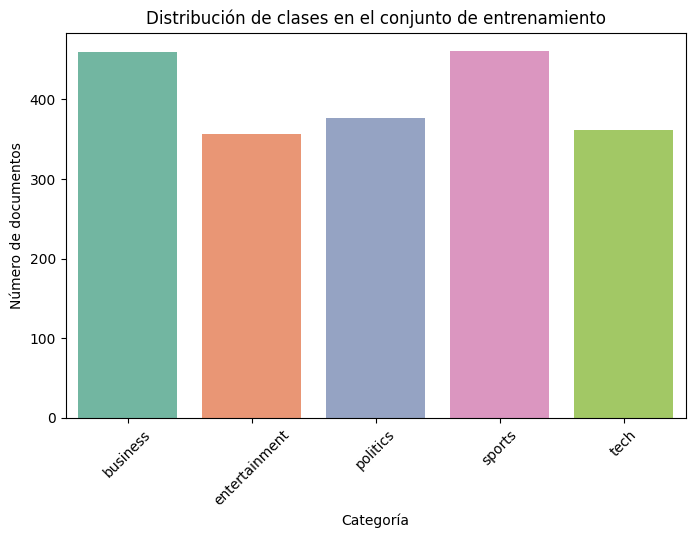

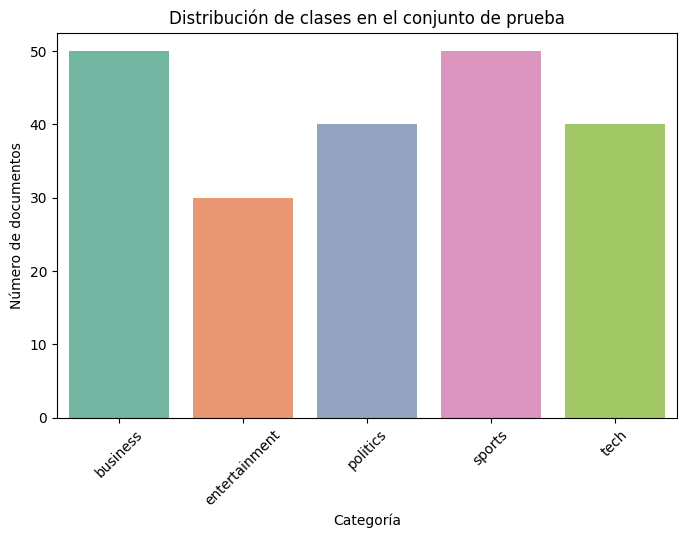

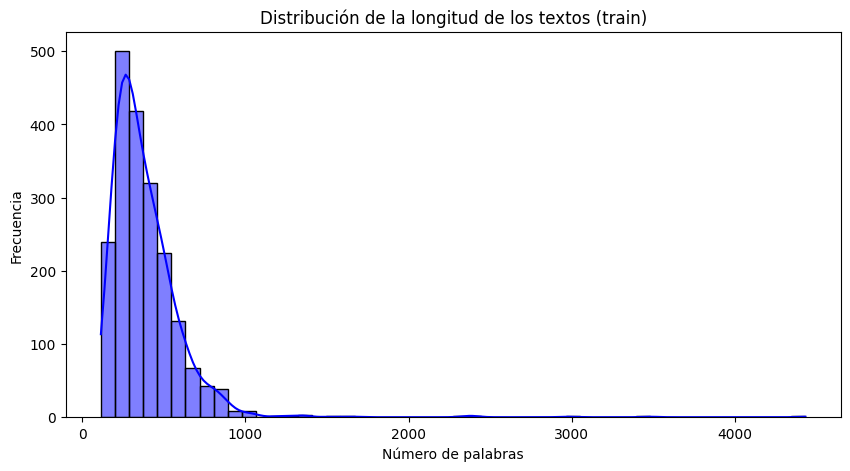

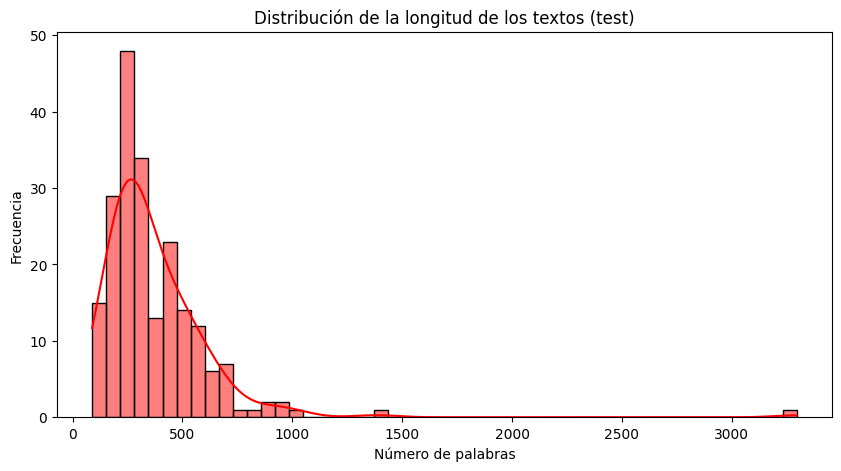

In [23]:
# Distribución de clases en el conjunto de entrenamiento
plt.figure(figsize=(8, 5))
sns.countplot(x="category", data=df_train, palette="Set2", hue="category")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Categoría")
plt.ylabel("Número de documentos")
plt.xticks(rotation=45)
plt.show()

# Distribución de clases en el conjunto de prueba
plt.figure(figsize=(8, 5))
sns.countplot(x="category", data=df_test, palette="Set2", hue="category")
plt.title("Distribución de clases en el conjunto de prueba")
plt.xlabel("Categoría")
plt.ylabel("Número de documentos")
plt.xticks(rotation=45)
plt.show()

# Estadísticas básicas sobre la longitud de los textos
df_train["text_length"] = df_train["text"].apply(lambda x: len(x.split()))
df_test["text_length"] = df_test["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(df_train["text_length"], bins=50, kde=True, color="blue")
plt.title("Distribución de la longitud de los textos (train)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_test["text_length"], bins=50, kde=True, color="red")
plt.title("Distribución de la longitud de los textos (test)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

## TD-IDF

In [24]:
vectorizer = TfidfVectorizer(max_features=5000)

df_train["processed_text"] = df_train["processed"].apply(lambda tokens: " ".join(tokens))
df_test["processed_text"] = df_test["processed"].apply(lambda tokens: " ".join(tokens))

X_train_tfidf = vectorizer.fit_transform(df_train["processed_text"])
X_test_tfidf = vectorizer.transform(df_test["processed_text"])

# Visualización de algunas palabras más relevantes por clase
feature_names = vectorizer.get_feature_names_out()
category_keywords = {}

for category in df_train["category"].unique():
    idx = df_train[df_train["category"] == category].index
    mean_tfidf = X_train_tfidf[idx].mean(axis=0)
    sorted_indices = mean_tfidf.argsort()[0, -10:].tolist()[0]
    category_keywords[category] = [feature_names[i] for i in sorted_indices]

keywords = {f"{category}": [] for category, _ in category_keywords.items()}
for category, words in category_keywords.items():
    keywords[category] = words

pd.DataFrame(keywords).T

0      1        2       3      4          5      6  \
business         rise  price  economi  growth   year     market   firm   
entertainment   oscar   year     band    good    say       show  music   
politics       minist  would    torus  govern  blair      parti  elect   
sports            cup   club     team   match    say     player    win   
tech           servic   user   comput   phone  peopl  technolog  mobil   

                     7      8     9  
business       compani   bank   say  
entertainment     star  award  film  
politics        labour    say    mr  
sports         england   play  game  
tech               say    use  game

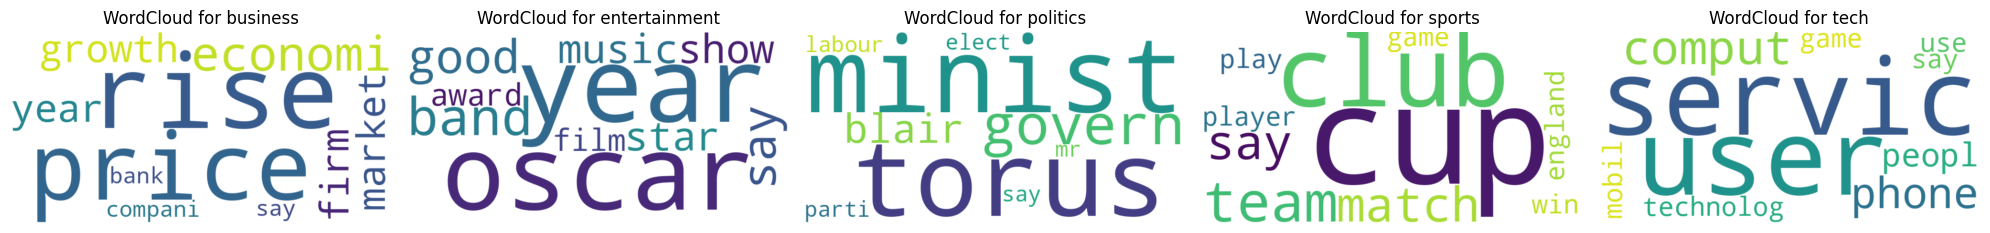

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for idx, (category, words) in enumerate(category_keywords.items()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))

    ax = axes[idx]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"WordCloud for {category}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [26]:
# --- Preparación de datos supervisados ---

# Mapeo explícito de etiquetas usando un diccionario
label_dict = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sports': 3,
    'tech': 4
}

# Agregar una columna numérica 'label' en los DataFrames
df_train["label"] = df_train["category"].map(label_dict)
df_test["label"] = df_test["category"].map(label_dict)

# Dividir df_train en entrenamiento y validación
from sklearn.model_selection import train_test_split

texts_train, texts_val, labels_train, labels_val = train_test_split(
    df_train["processed_text"].tolist(),
    df_train["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_train["label"]
)

# Preparar el conjunto de test (se mantiene igual)
texts_test = df_test["processed_text"].tolist()
labels_test = df_test["label"].tolist()

print("Ejemplos de entrenamiento:", len(texts_train))
print("Ejemplos de validación:", len(texts_val))
print("Ejemplos de test:", len(texts_test))


Ejemplos de entrenamiento: 1612
Ejemplos de validación: 403
Ejemplos de test: 210


## Word Embeddings Word2Vec

In [27]:
sentences = df_train["processed"].apply(lambda x: ' '.join(x)).tolist()
doc = nlp(" ".join(sentences))  # Procesar todo el texto

# Ver los vectores de las palabras
word_vectors = {}
for token in doc:
    if not token.is_stop and not token.is_punct:  # Ignorar stopwords y puntuación
        word_vectors[token.text] = token.vector

# Para visualizar las palabras más similares a una palabra, por ejemplo "government":
target_word = "government"

# Verificar si la palabra está en el vocabulario de SpaCy
if target_word in word_vectors:
    target_vector = word_vectors[target_word]

    # Calcular la similitud coseno entre "government" y las demás palabras
    similarities = {}
    for word, vector in word_vectors.items():
        similarity = target_vector @ vector / (np.linalg.norm(target_vector) * np.linalg.norm(vector))
        similarities[word] = similarity

    # Obtener las top 10 palabras más similares
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    top_10_similar = sorted_similarities[:10]

    print("Palabras más similares a 'government':")
    for word, sim in top_10_similar:
        print(f"{word}: {sim:.4f}")
else:
    print(f"La palabra '{target_word}' no está en el vocabulario.")

Palabras más similares a 'government':
government: 1.0000
deadli: 0.7365
flatman: 0.7324
boyzon: 0.7293
art: 0.7276
counsellor: 0.7269
brain: 0.7259
fund: 0.7254
composit: 0.7227
deodor: 0.7212


## Setence Embeddings

In [28]:
# Modelo de embeddings de oraciones
model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


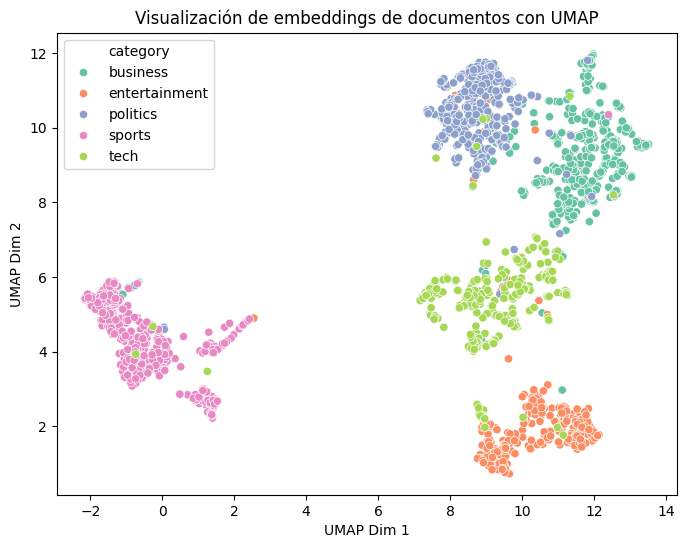

In [29]:
# Generar embeddings
X_train_embeddings = model.encode(df_train["processed_text"])
X_test_embeddings = model.encode(df_test["processed_text"])

# Reducir dimensionalidad con UMAP
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine")
X_reduced = reducer.fit_transform(X_train_embeddings)

# Graficar
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df_train["category"], palette="Set2")
plt.title("Visualización de embeddings de documentos con UMAP")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.show()

## LDA

In [30]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_train_tfidf)

# Mostrar las palabras más representativas de cada tema
for idx, topic in enumerate(lda.components_):
    print(f"Tema {df_train['category'].unique()[idx]}: {[feature_names[i] for i in topic.argsort()[-10:]]}")

Tema business: ['peopl', 'phone', 'technolog', 'england', 'play', 'use', 'mobil', 'player', 'say', 'game']
Tema entertainment: ['minist', 'year', 'blair', 'parti', 'labour', 'elect', 'govern', 'would', 'mr', 'say']
Tema politics: ['anil', 'verizon', 'qanta', 'relianc', 'juninho', 'domain', 'bellami', 'mci', 'fiat', 'gm']
Tema sports: ['pernod', 'blackberri', 'hsdpa', 'vodafon', 'multimedia', 'reddi', 'cabir', 'simonetti', 'mda', 'uwb']
Tema tech: ['rise', 'bank', 'star', 'growth', 'market', 'sale', 'say', 'year', 'award', 'film']


# BERT (supervisado)

In [ ]:
# --- Modelo Supervisado (Clasificación con BERT) ---

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx])
        }

# Tokenización
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Usar los conjuntos de datos preparados:
train_dataset = NewsDataset(texts_train, labels_train, tokenizer)
val_dataset = NewsDataset(texts_val, labels_val, tokenizer)
test_dataset = NewsDataset(texts_test, labels_test, tokenizer)

In [ ]:
# Definir métricas
def compute_metrics(eval_pred):
    metric_accuracy = load("accuracy")
    metric_f1 = load("f1")
    metric_precision = load("precision")
    metric_recall = load("recall")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": metric_f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
        "precision": metric_precision.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": metric_recall.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    }

In [ ]:
# Configurar y entrenar el modelo BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    eval_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Usamos el conjunto de validación durante el entrenamiento
    compute_metrics=compute_metrics
)

trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cdf51342 (cdf51342-universidad-carlos-iii-de-madrid) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=1260, training_loss=0.1346075213144696, metrics={'train_runtime': 1125.2106, 'train_samples_per_second': 8.954, 'train_steps_per_second': 1.12, 'total_flos': 2650915285324800.0, 'train_loss': 0.1346075213144696, 'epoch': 5.0})

In [ ]:
# Evaluación final en el conjunto de test
results = trainer.evaluate(eval_dataset=test_dataset)
print("Resultados en conjunto de test:", results)

Resultados en conjunto de test: {'eval_loss': 0.03498785197734833, 'eval_runtime': 6.5581, 'eval_samples_per_second': 32.022, 'eval_steps_per_second': 4.117, 'epoch': 5.0}


In [ ]:
# Definir el directorio donde se guardará el modelo
output_dir = "./models/modelBERT"

# Guardar el modelo y el tokenizador
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Modelo guardado en {output_dir}")

Modelo guardado en ./models/modelBERT


# Búsqueda del mejor modelo no supervisado (LDA)

## Funciones auxiliares

In [60]:
# Visualización de los temas
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Tema {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Nube de palabras
def plot_wordclouds(model, feature_names, num_topics):
    fig, axes = plt.subplots(1, num_topics, figsize=(15, 5))
    for topic_idx, topic in enumerate(model.components_):
        word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-15 - 1:-1]}
        wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_freq)
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].axis("off")
        axes[topic_idx].set_title(f"Tema {topic_idx+1}")
    plt.show()

def plot_topic_distribution(df, key):
    plt.figure(figsize=(8,5))
    sns.countplot(x=df["assigned_topic"], palette="Set2", hue=df["category"])
    plt.xlabel("Temas asignados por LDA")
    plt.ylabel("Número de documentos")
    plt.title(f"Distribución de documentos por tema - {key}")
    plt.show()

# Comparación entre temas asignados y categorías reales
def plot_category_vs_topic(df, key):
    plt.figure(figsize=(12,6))
    sns.countplot(x=df["assigned_topic"], hue=df["category"], palette="Set2")
    plt.xlabel("Temas asignados por LDA")
    plt.ylabel("Número de documentos")
    plt.title(f"Comparación entre temas asignados y categorías reales - {key}")
    plt.legend(title="Categoría real", bbox_to_anchor=(1,1))
    plt.show()

# Comparación visual de las métricas evaluadas
def plot_results(results):
    # Convertir los resultados en un DataFrame y trasponer
    df_results = pd.DataFrame(results).T

    # Extraer 'ngram_range' desde las claves del índice usando split
    df_results['ngram_range'] = df_results.index.map(lambda x: int(x.split("_")[2]))

    # Obtener valores únicos de ngram_range y ordenarlos
    ngram_ranges = sorted(df_results['ngram_range'].unique())

    # Iterar sobre cada ngram_range
    for ngram_range in ngram_ranges:
        # Filtrar los resultados para el ngram_range actual
        df_ngram = df_results[df_results['ngram_range'] == ngram_range]

        # Crear una figura con 1 fila y 2 columnas para las gráficas
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # Gráfica de Perplexity
        if "perplexity" in df_ngram.columns:
            df_ngram[["perplexity"]].dropna().plot(kind="bar", legend=False, ax=axes[0])
            axes[0].set_title(f"Comparación de Perplexity (ngram_range: {ngram_range})")
            axes[0].set_ylabel("Perplexity")
            axes[0].set_xticks(range(len(df_ngram)))  # Asegura la correcta alineación
            axes[0].set_xticklabels(df_ngram.index, rotation=30, ha="right")

        # Gráfica de otras métricas
        other_metrics = df_ngram.drop(columns=["perplexity", "ngram_range"], errors='ignore')
        if not other_metrics.empty:
            other_metrics.plot(kind="bar", ax=axes[1])
            axes[1].set_title(f"Comparación de métricas (ngram_range: {ngram_range})")
            axes[1].set_xticks(range(len(df_ngram)))  # Asegura la correcta alineación
            axes[1].set_xticklabels(df_ngram.index, rotation=30, ha="right")

        # Ajustar el diseño
        plt.tight_layout()
        plt.show()

## Métricas a evaluar

In [32]:
# Función para evaluar Perplexity
def lda_perplexity_score(model, X):
    return -model.perplexity(X)  # Negativo porque GridSearchCV maximiza la métrica

# Función para calcular Purity Score
def purity_score(y_true, y_pred):
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

# Métrica personalizada para GridSearchCV
def lda_purity_scorer(estimator, X, y_true):
    assigned_topics = np.argmax(estimator.transform(X), axis=1)
    return purity_score(y_true, assigned_topics)

perplexity_scorer = make_scorer(lda_perplexity_score, greater_is_better=True)

## Búsqueda de 5 temas

In [33]:
# Función para representar texto con diferentes n-gramas
def represent_text(df, method, ngram_range=(1,1), max_features=1000):
    processed_str = df["processed"].apply(lambda x: " ".join(x))

    if method == "bow":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    else:
        raise ValueError("Método no válido")

    return vectorizer, vectorizer.fit_transform(processed_str)

In [34]:
# Evaluación en df_test con GridSearchCV usando n-gramas
representations = ["bow", "tfidf"]
n_gram_ranges = [(1,1), (1,2), (1,3)]
max_features = [500, 1000, 1500, 2000]

param_grid = {"learning_decay": [0.3, 0.5, 0.7, 0.9]}
results = {}
models = {}

for rep in representations:
    for max_feature in max_features:
      for ngram_range in n_gram_ranges:
          vectorizer, X_train = represent_text(df_train, method=rep, ngram_range=ngram_range, max_features=max_feature)
          X_test = vectorizer.transform(df_test["processed_text"])

          grid_search = GridSearchCV(LatentDirichletAllocation(n_components=5, random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1, scoring=lda_purity_scorer)
          grid_search.fit(X_train, df_train["category"])
          best_lda = grid_search.best_estimator_
          best_params = grid_search.best_params_
          best_score = grid_search.best_score_

          print(f"Mejores hiperparámetros para {rep} con n-gramas {ngram_range}: {best_params}")

          perplexity = best_lda.perplexity(X_test)

          # Diversidad de temas
          assigned_topics = np.argmax(best_lda.transform(X_test), axis=1)
          topic_diversity = len(set(assigned_topics)) / 5

          # Divergencia de Jensen-Shannon
          topic_distributions = best_lda.transform(X_test)
          js_divergence = np.mean([jensenshannon(topic_distributions[i], topic_distributions[j])
                                  for i in range(len(topic_distributions))
                                  for j in range(i+1, len(topic_distributions))])

          # Purity Score
          purity = purity_score(df_test["category"], assigned_topics)

          results[f"{rep}_ngram_{ngram_range[1]}_maxfeature_{max_feature}"] = {"perplexity": perplexity, "topic_diversity": topic_diversity, "js_divergence": js_divergence, "purity_score": purity}
          models[f"{rep}_ngram_{ngram_range[1]}_maxfeature_{max_feature}"] = {"model": best_lda, "params": best_params, "score": purity}

          print(f"\nRepresentación: {rep} con n-gramas {ngram_range} - Perplexity: {perplexity}, Diversidad de Temas: {topic_diversity}, JS Divergence: {js_divergence}, Purity Score: {purity}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros para bow con n-gramas (1, 1): {'learning_decay': 0.3}

Representación: bow con n-gramas (1, 1) - Perplexity: 372.7879888422141, Diversidad de Temas: 1.0, JS Divergence: 0.6342364428709216, Purity Score: 0.9238095238095239
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros para bow con n-gramas (1, 2): {'learning_decay': 0.3}

Representación: bow con n-gramas (1, 2) - Perplexity: 385.20090676087733, Diversidad de Temas: 1.0, JS Divergence: 0.6128817120797965, Purity Score: 0.6904761904761905
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros para bow con n-gramas (1, 3): {'learning_decay': 0.3}

Representación: bow con n-gramas (1, 3) - Perplexity: 385.20090676087733, Diversidad de Temas: 1.0, JS Divergence: 0.6128817120797965, Purity Score: 0.6904761904761905
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámet

## Evaluación

In [44]:
df_results = pd.DataFrame(results)
df_results.to_csv('results_lda.csv')
df_results

bow_ngram_1_maxfeature_500  bow_ngram_2_maxfeature_500  \
perplexity                       372.787989                  385.200907   
topic_diversity                    1.000000                    1.000000   
js_divergence                      0.634236                    0.612882   
purity_score                       0.923810                    0.690476   

                 bow_ngram_3_maxfeature_500  bow_ngram_1_maxfeature_1000  \
perplexity                       385.200907                   727.943996   
topic_diversity                    1.000000                     1.000000   
js_divergence                      0.612882                     0.631768   
purity_score                       0.690476                     0.919048   

                 bow_ngram_2_maxfeature_1000  bow_ngram_3_maxfeature_1000  \
perplexity                        735.355913                   737.947534   
topic_diversity                     1.000000                     1.000000   
js_divergence                       0.610673                     0.621748   
purity_score                        0.828571                     0.833333   

                 bow_ngram_1_maxfeature_1500  bow_ngram_2_maxfeature_1500  \
perplexity                       1104.862876                  1075.731791   
topic_diversity                     1.000000                     1.000000   
js_divergence                       0.616451                     0.635650   
purity_score                        0.757143                     0.923810   

                 bow_ngram_3_maxfeature_1500  bow_ngram_1_maxfeature_2000  \
perplexity                       1149.253283                  1417.089283   
topic_diversity                     1.000000                     1.000000   
js_divergence                       0.613416                     0.608579   
purity_score                        0.771429                     0.776190   

                 ...  tfidf_ngram_3_maxfeature_500  \
perplexity       ...                   5297.834115   
topic_diversity  ...                      0.800000   
js_divergence    ...                      0.517742   
purity_score     ...                      0.719048   

                 tfidf_ngram_1_maxfeature_1000  tfidf_ngram_2_maxfeature_1000  \
perplexity                        20496.143050                   20533.063487   
topic_diversity                       0.800000                       0.800000   
js_divergence                         0.481977                       0.528099   
purity_score                          0.657143                       0.819048   

                 tfidf_ngram_3_maxfeature_1000  tfidf_ngram_1_maxfeature_1500  \
perplexity                        20910.507366                   72590.458369   
topic_diversity                       0.800000                       1.000000   
js_divergence                         0.535032                       0.526571   
purity_score                          0.828571                       0.776190   

                 tfidf_ngram_2_maxfeature_1500  tfidf_ngram_3_maxfeature_1500  \
perplexity                        78037.303431                   41386.479644   
topic_diversity                       1.000000                       0.800000   
js_divergence                         0.568934                       0.458346   
purity_score                          0.942857                       0.657143   

                 tfidf_ngram_1_maxfeature_2000  tfidf_ngram_2_maxfeature_2000  \
perplexity                        89019.190960                   90650.526360   
topic_diversity                       0.800000                       1.000000   
js_divergence                         0.490225                       0.469579   
purity_score                          0.671429                       0.638095   

                 tfidf_ngram_3_maxfeature_2000  
perplexity                        65406.487908  
topic_diversity                       0.600000  
js_divergence                         0.454956  
purity_scor

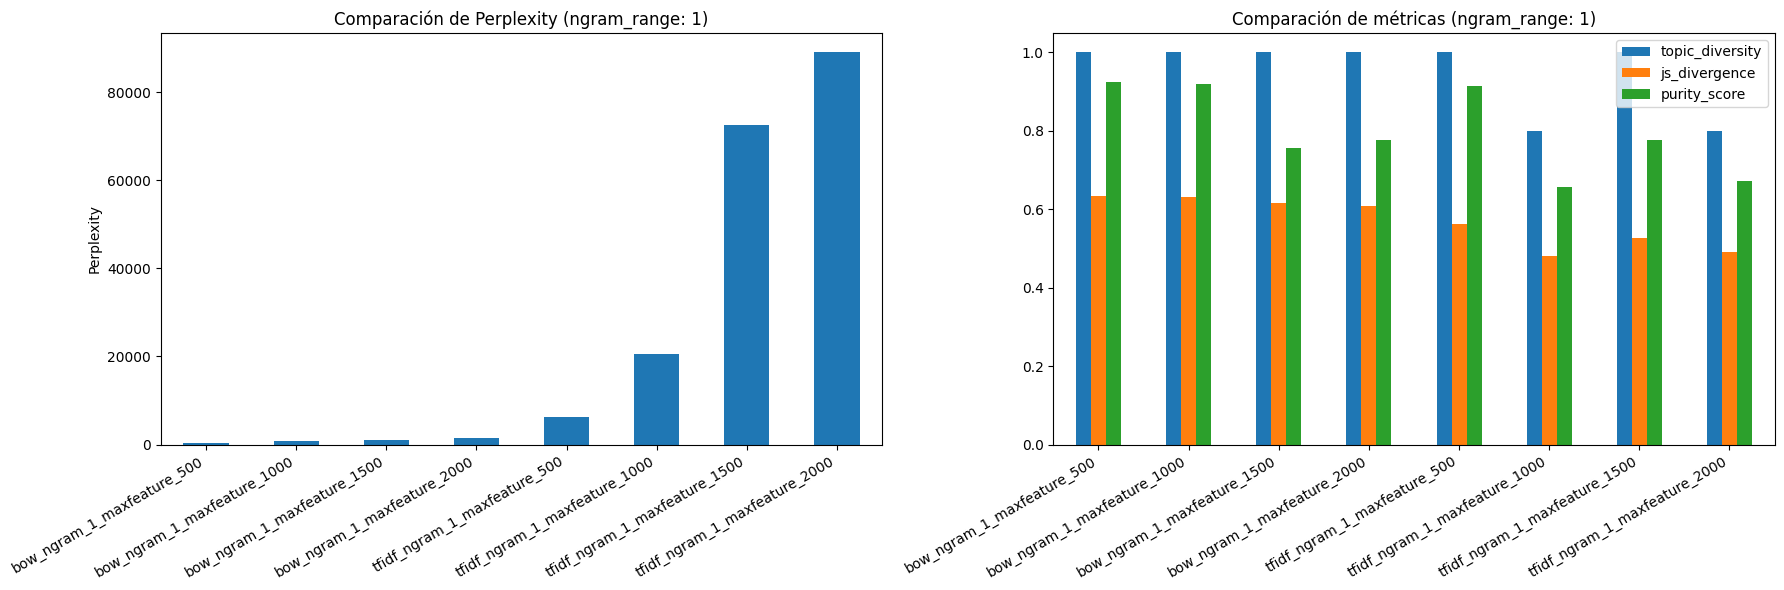

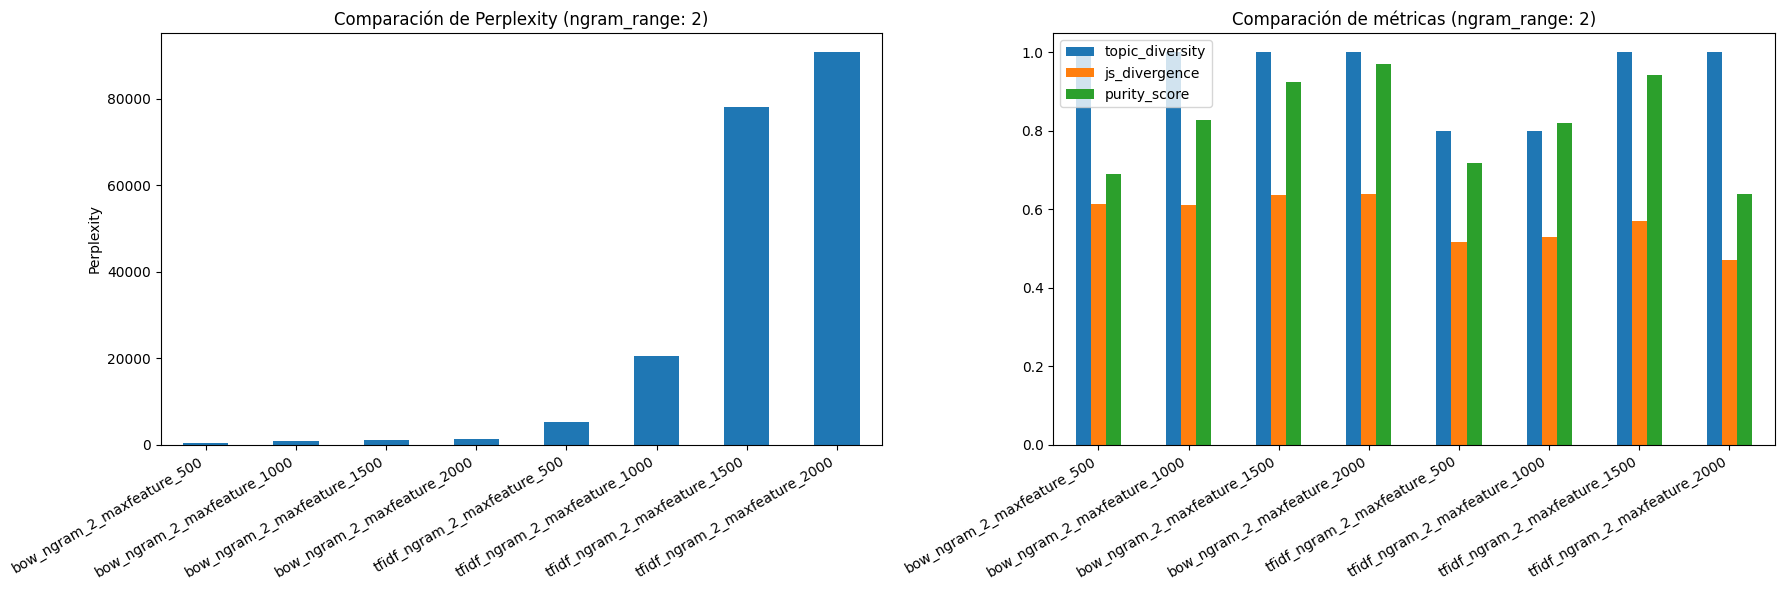

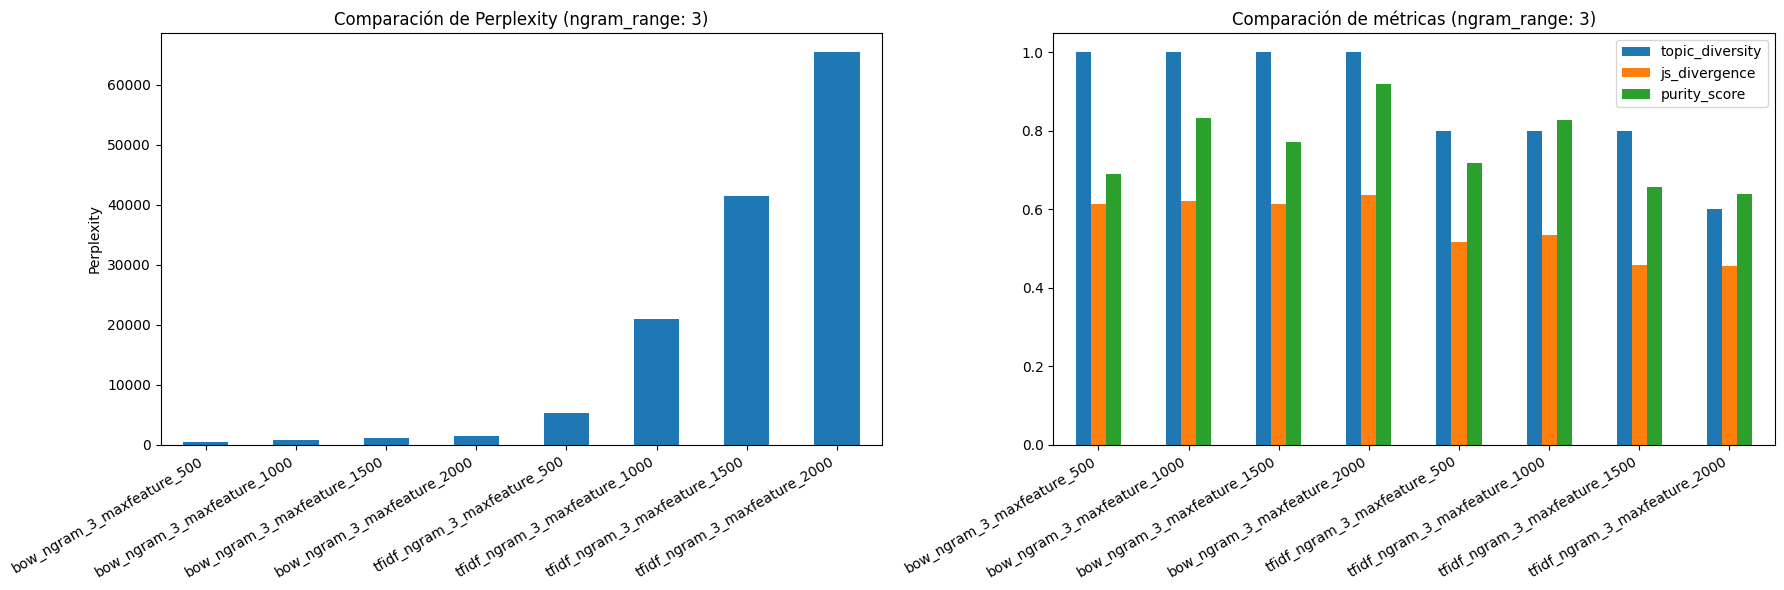

In [58]:
plot_results(results)



Graphics bow_ngram_1_maxfeature_500




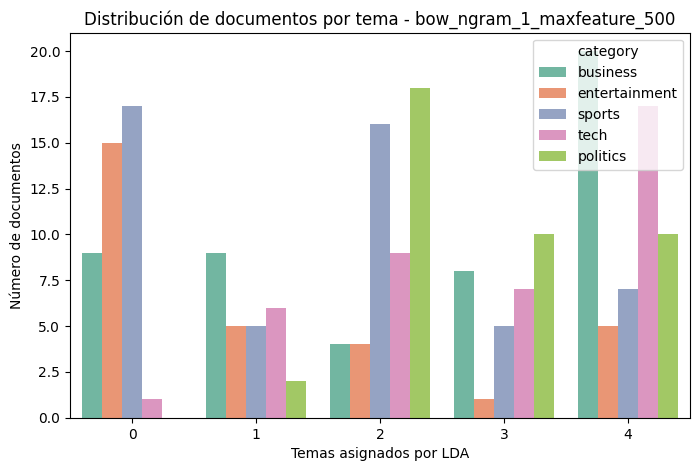

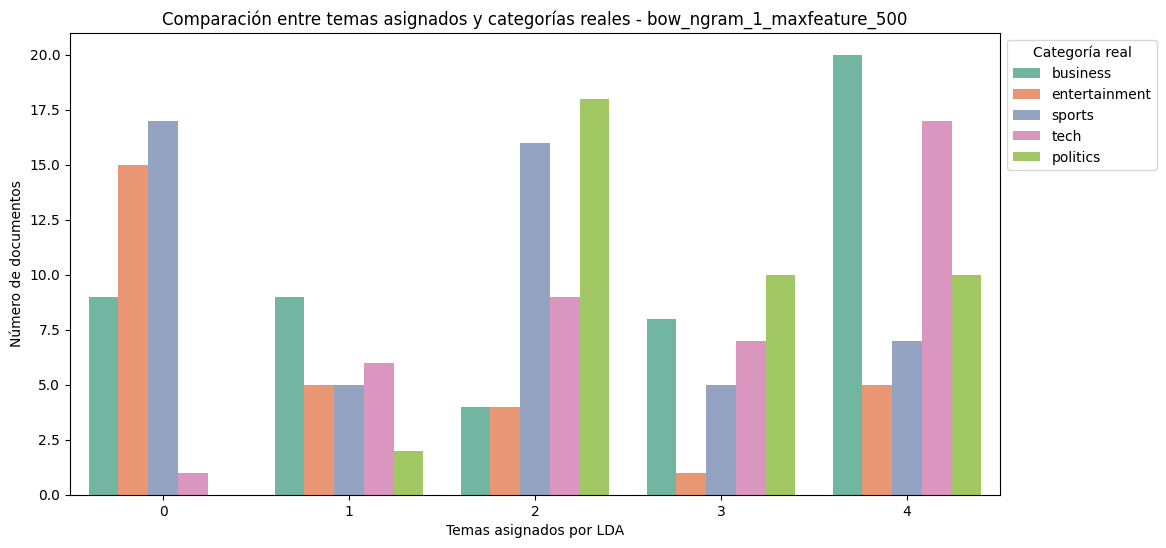

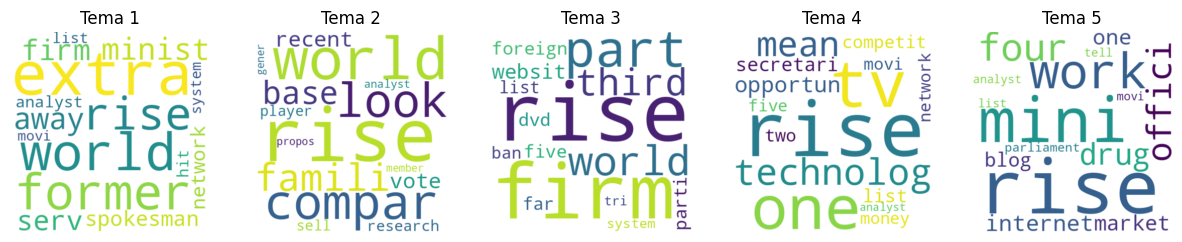



Graphics bow_ngram_2_maxfeature_500




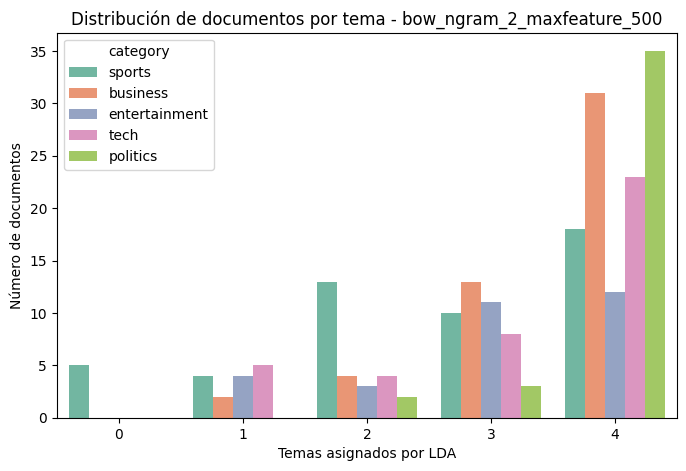

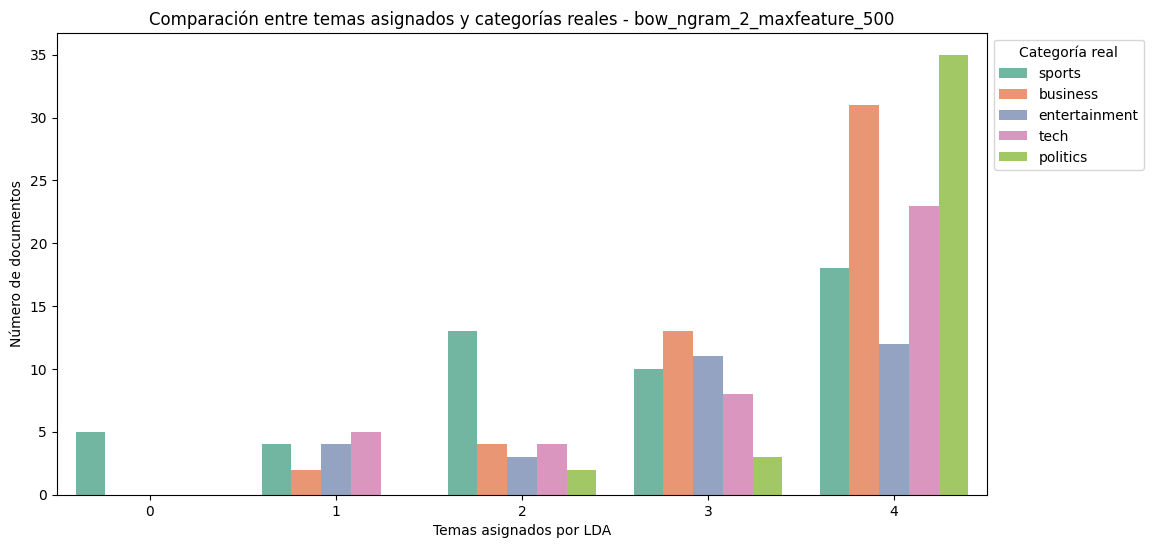

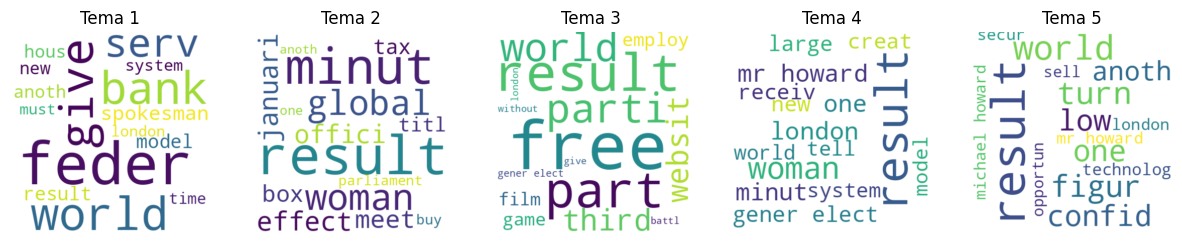



Graphics bow_ngram_3_maxfeature_500




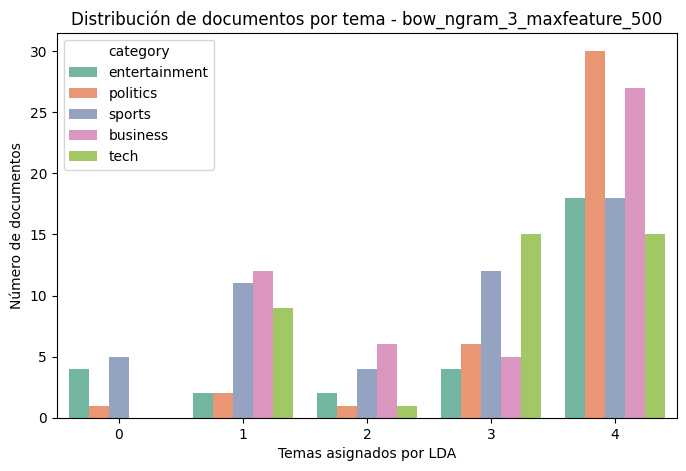

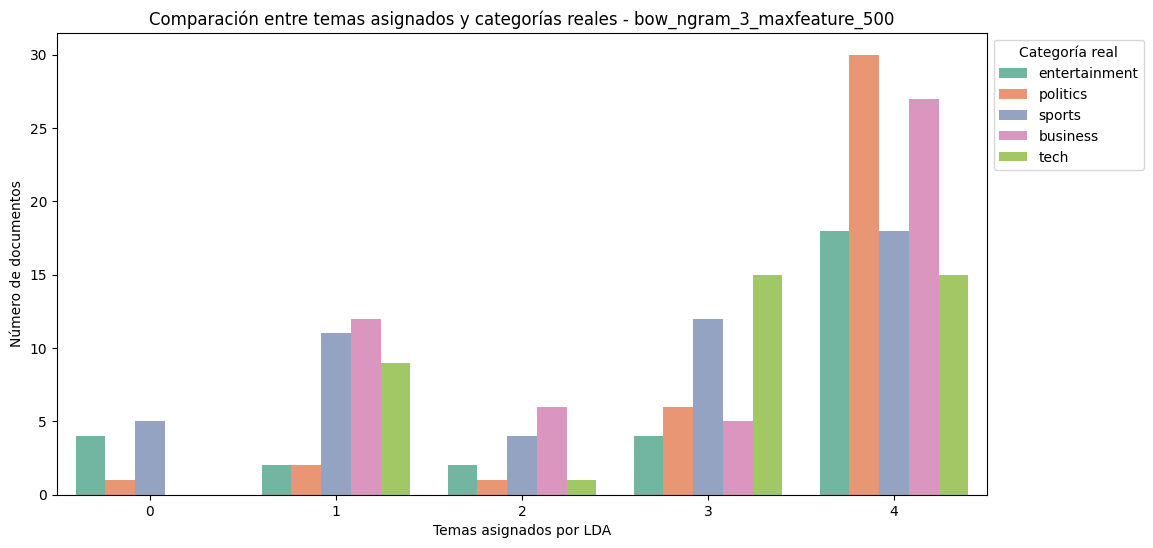

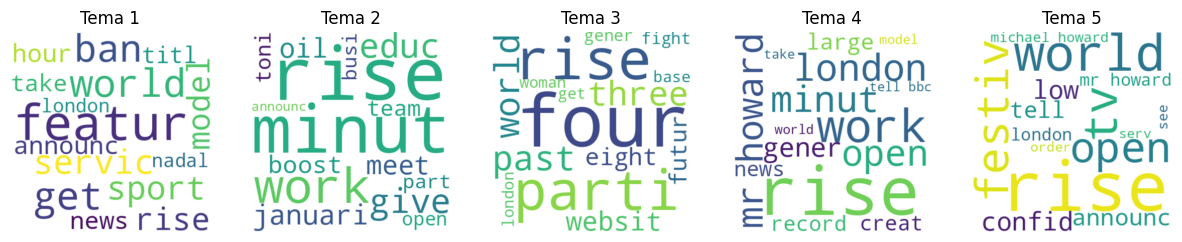



Graphics bow_ngram_1_maxfeature_1000




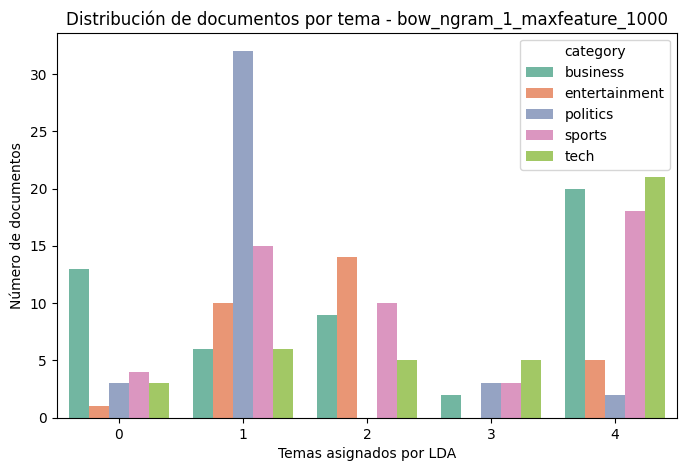

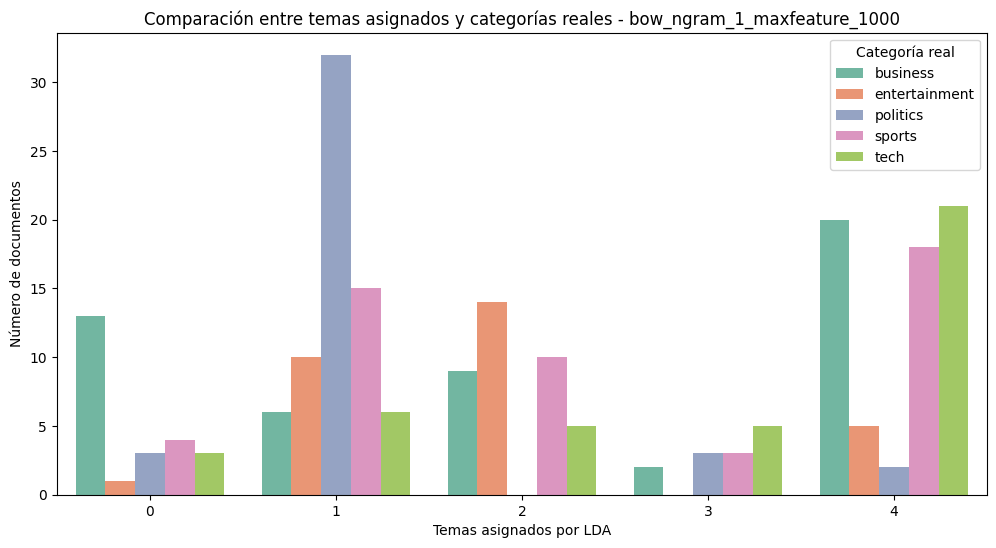

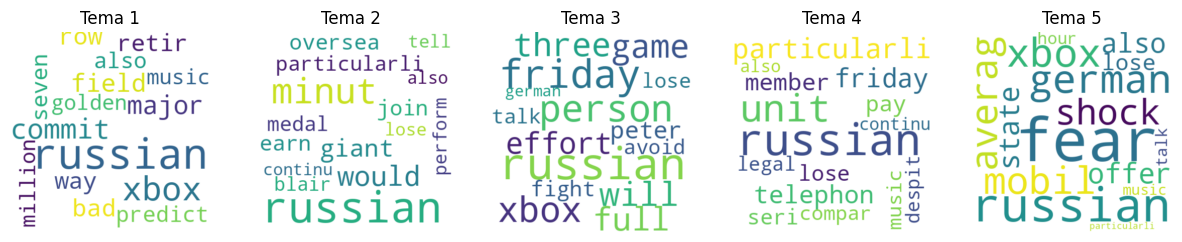



Graphics bow_ngram_2_maxfeature_1000




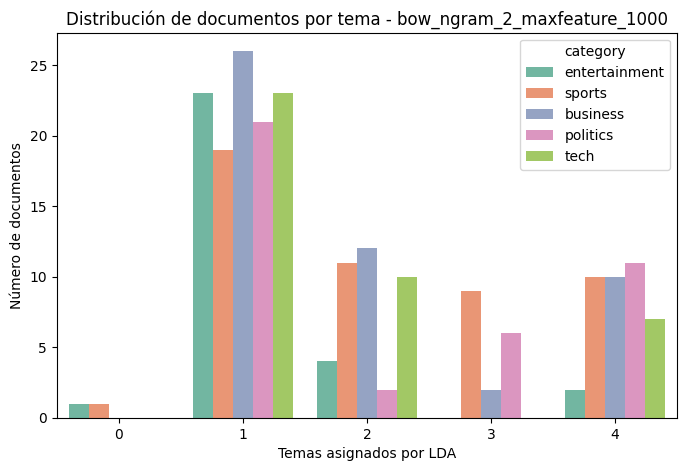

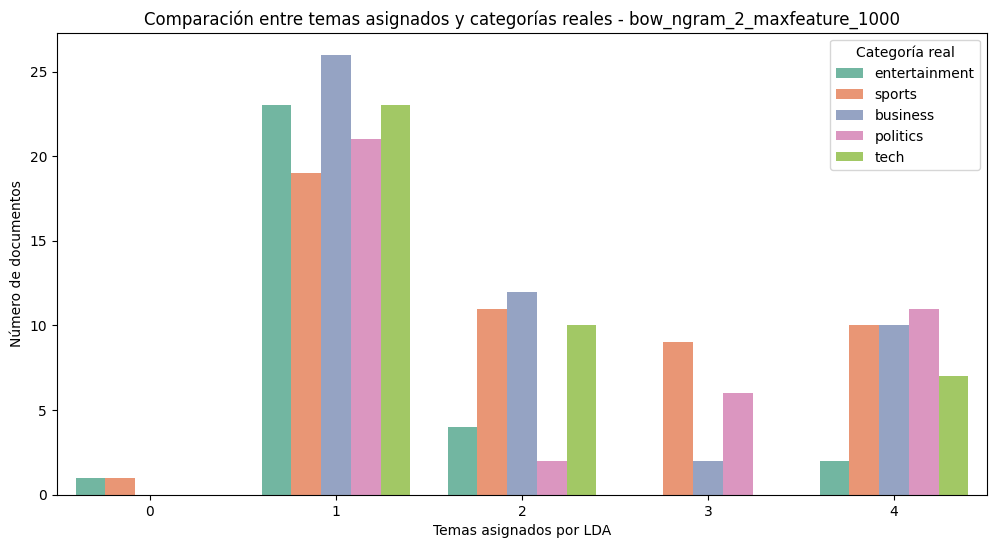

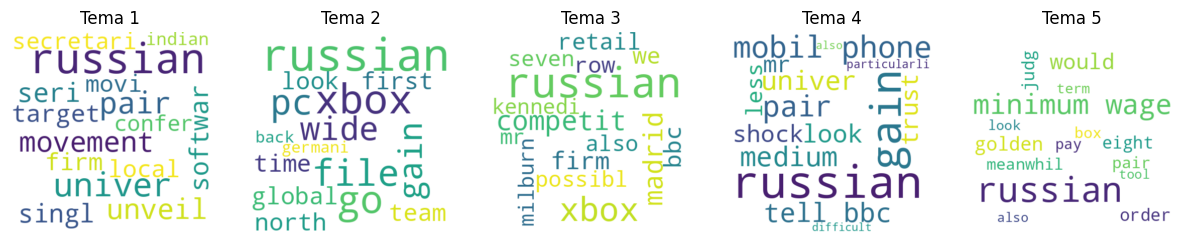



Graphics bow_ngram_3_maxfeature_1000




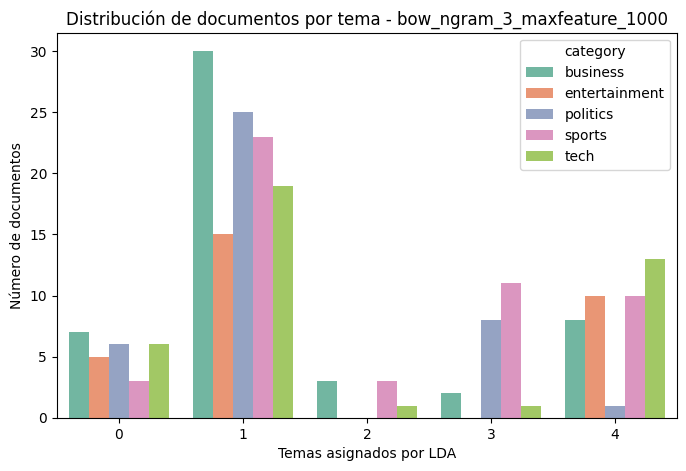

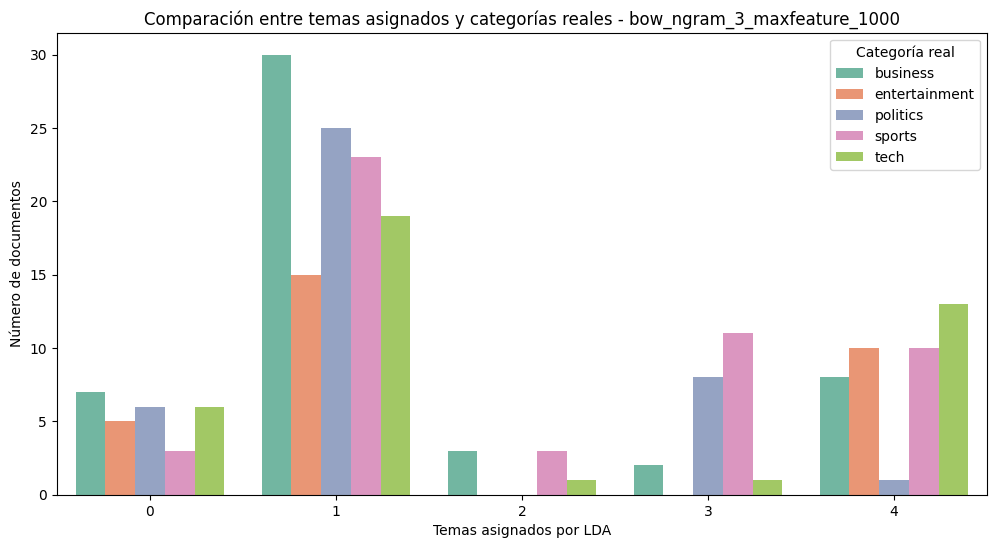

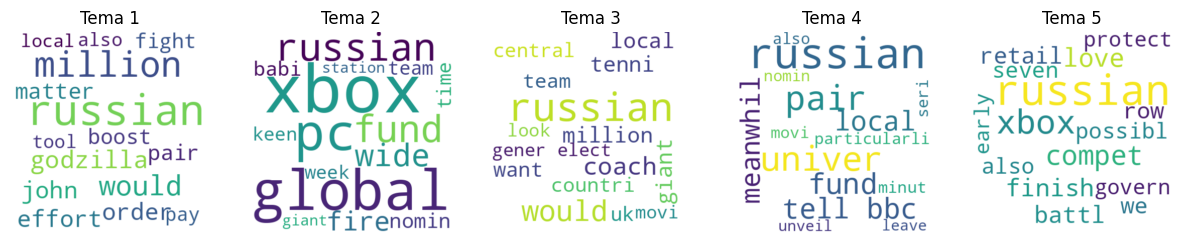



Graphics bow_ngram_1_maxfeature_1500




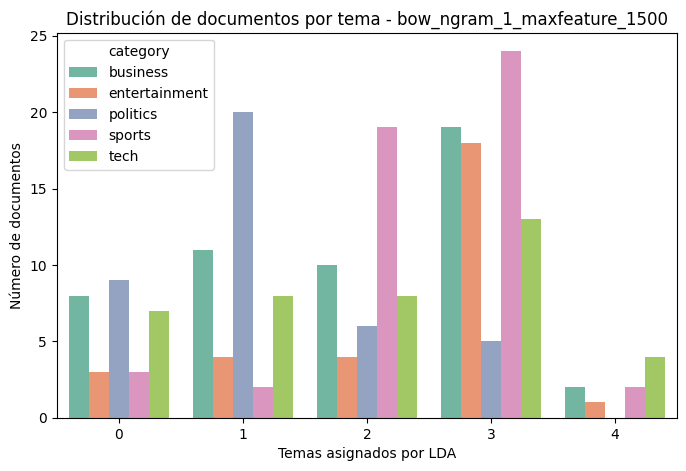

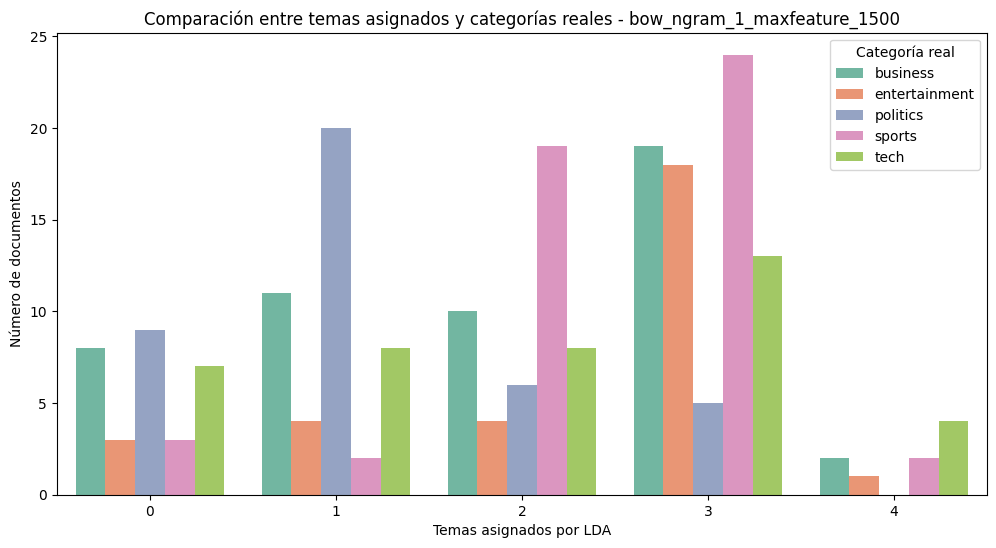

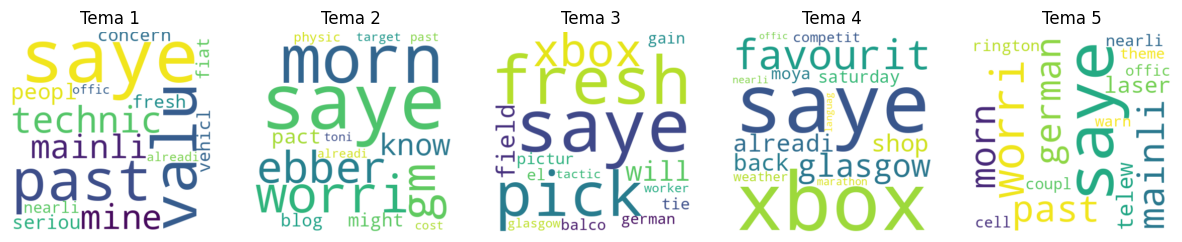



Graphics bow_ngram_2_maxfeature_1500




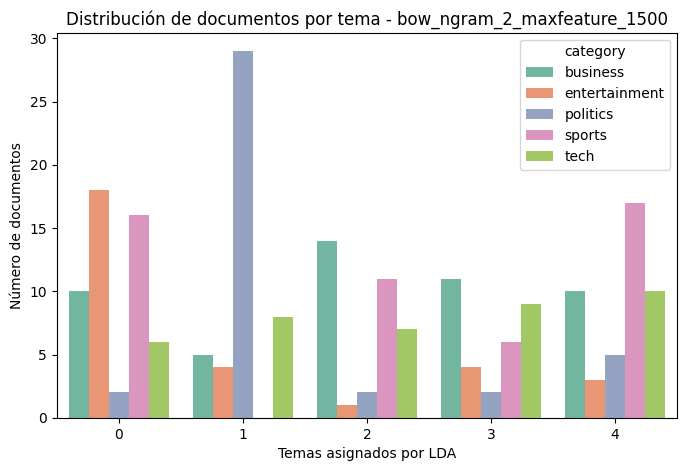

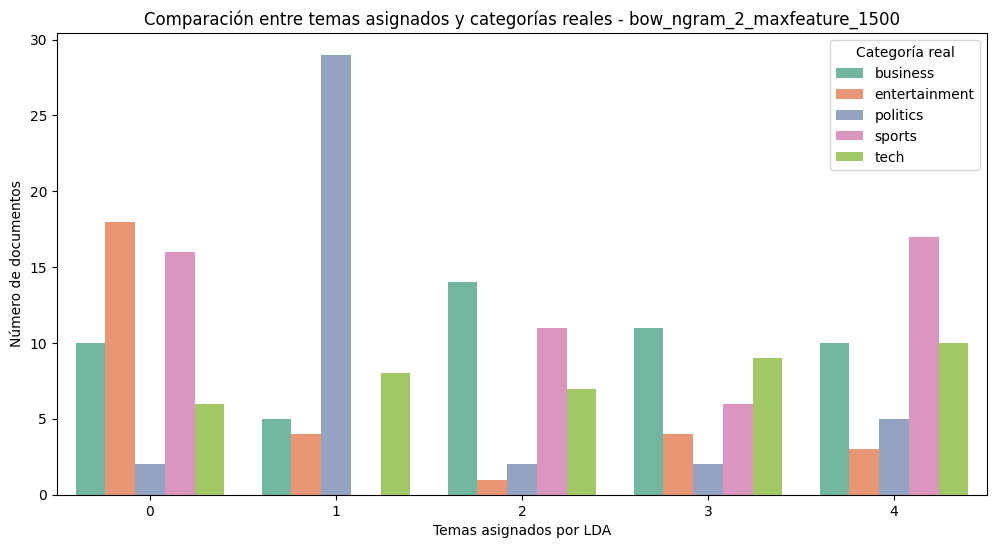

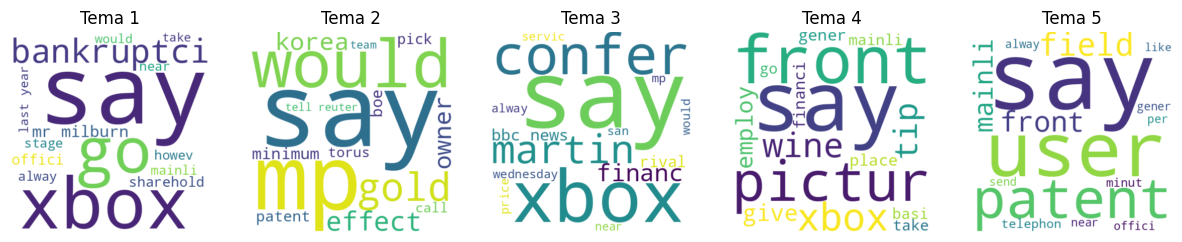



Graphics bow_ngram_3_maxfeature_1500




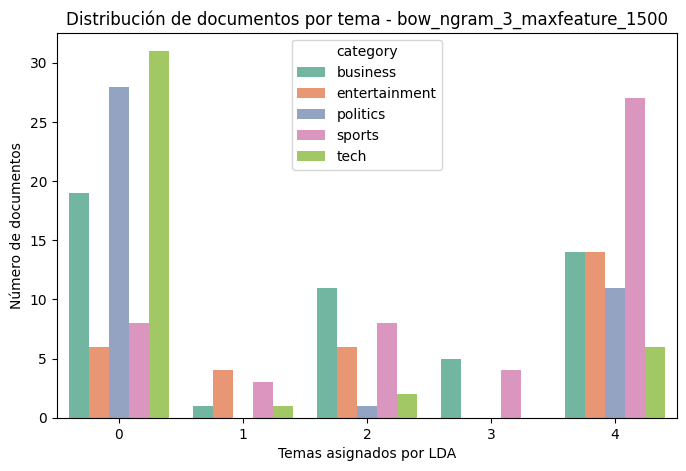

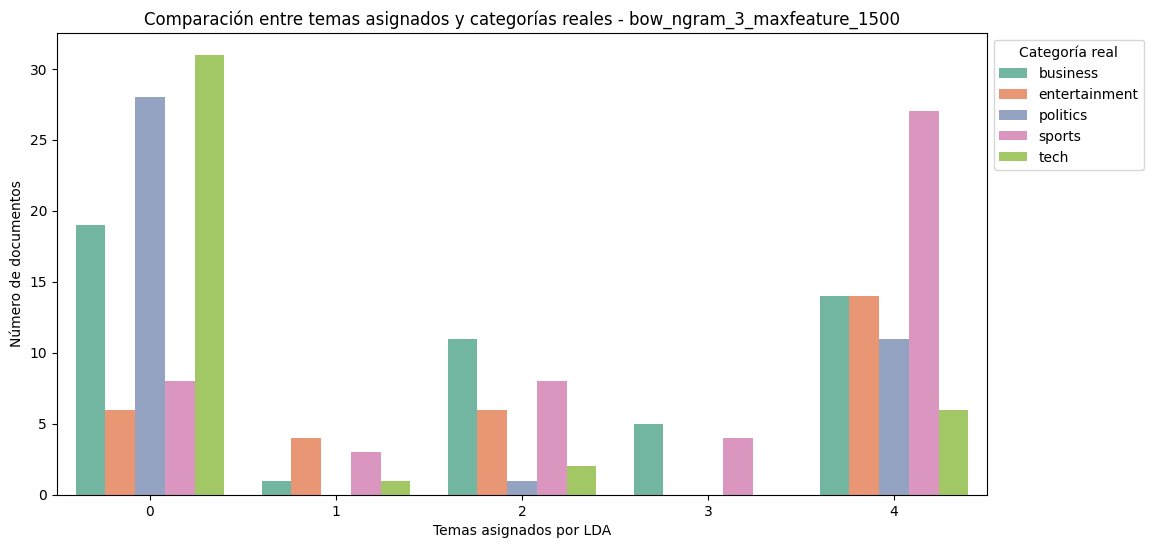

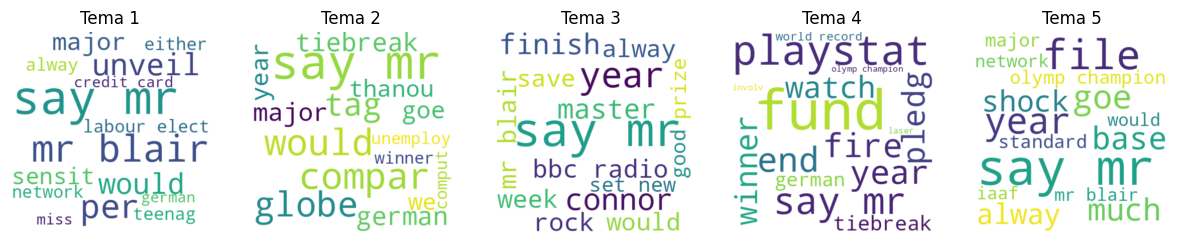



Graphics bow_ngram_1_maxfeature_2000




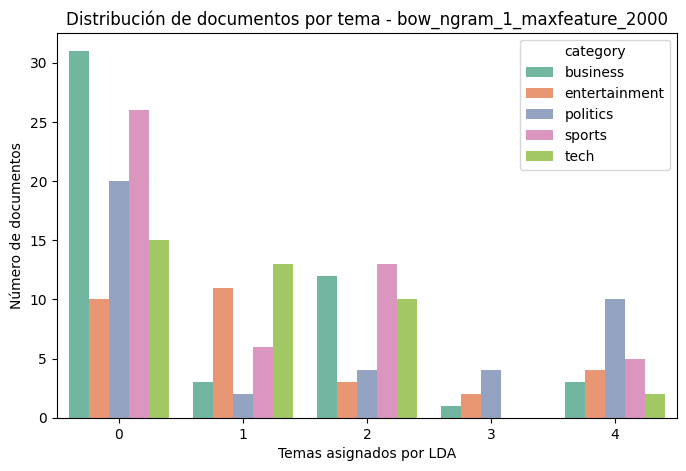

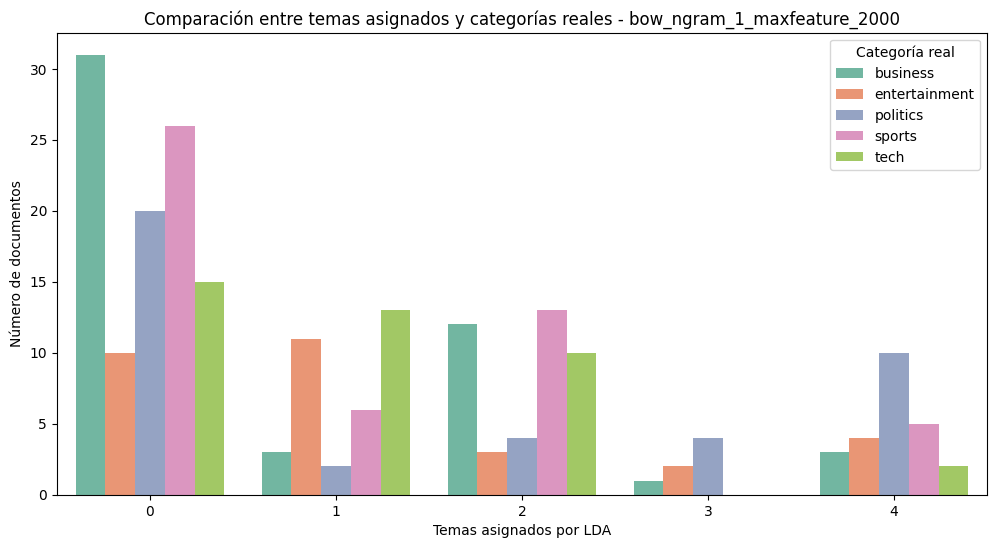

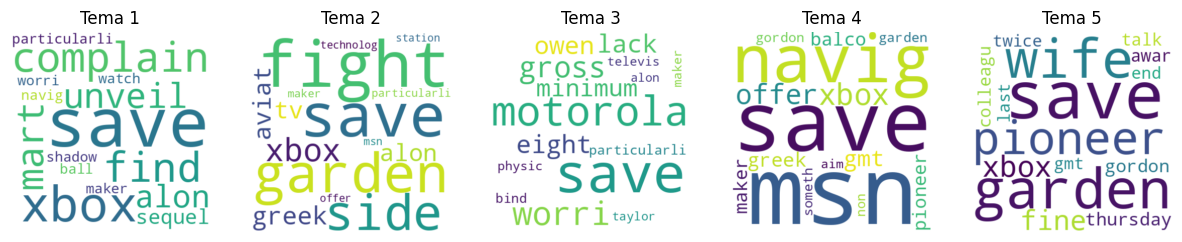



Graphics bow_ngram_2_maxfeature_2000




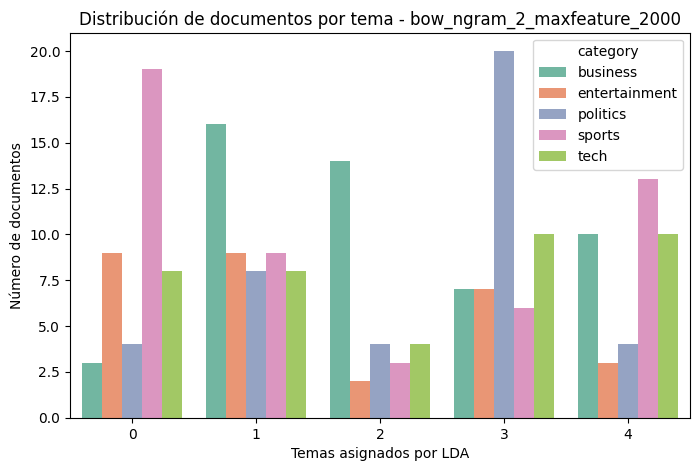

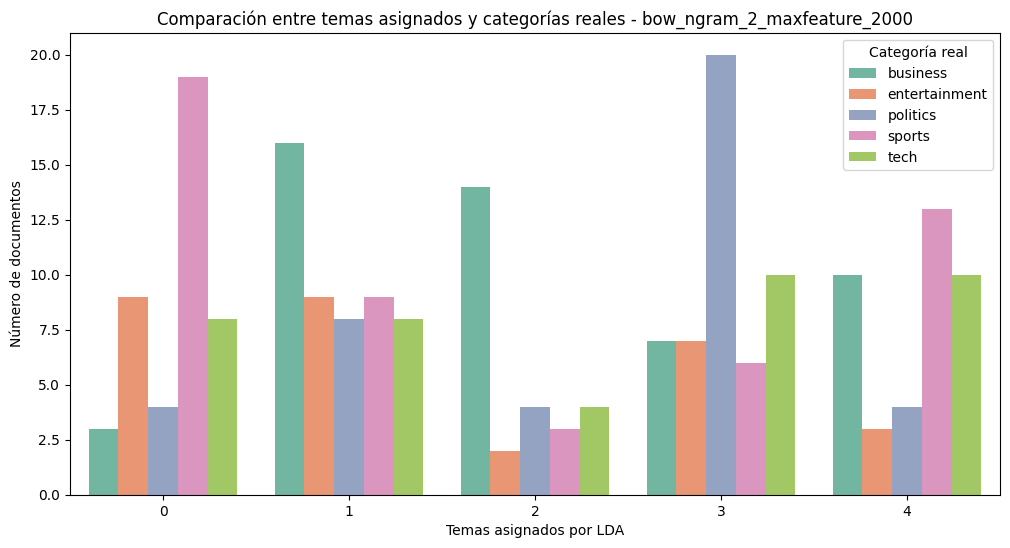

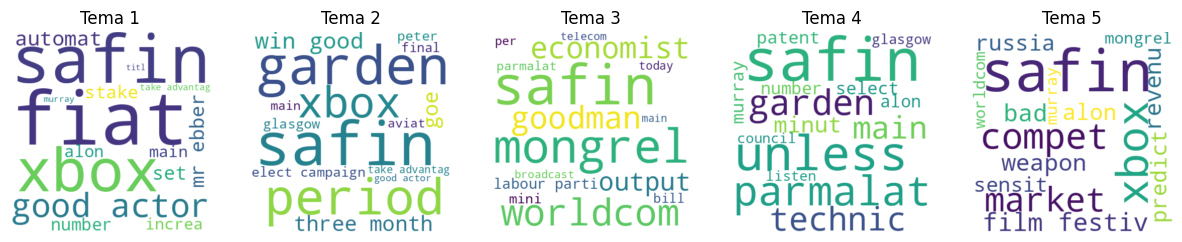



Graphics bow_ngram_3_maxfeature_2000




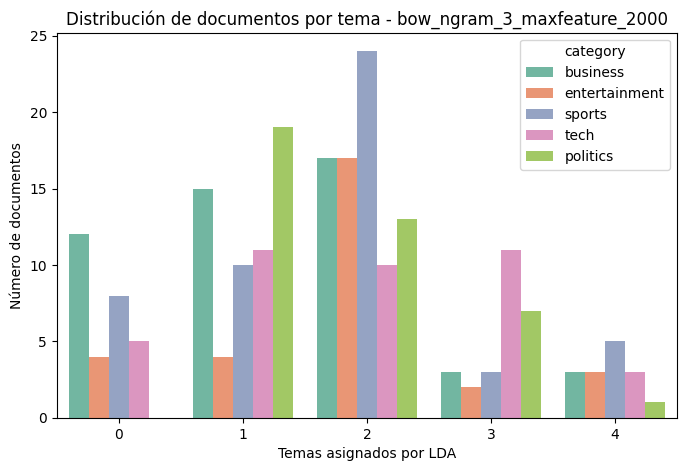

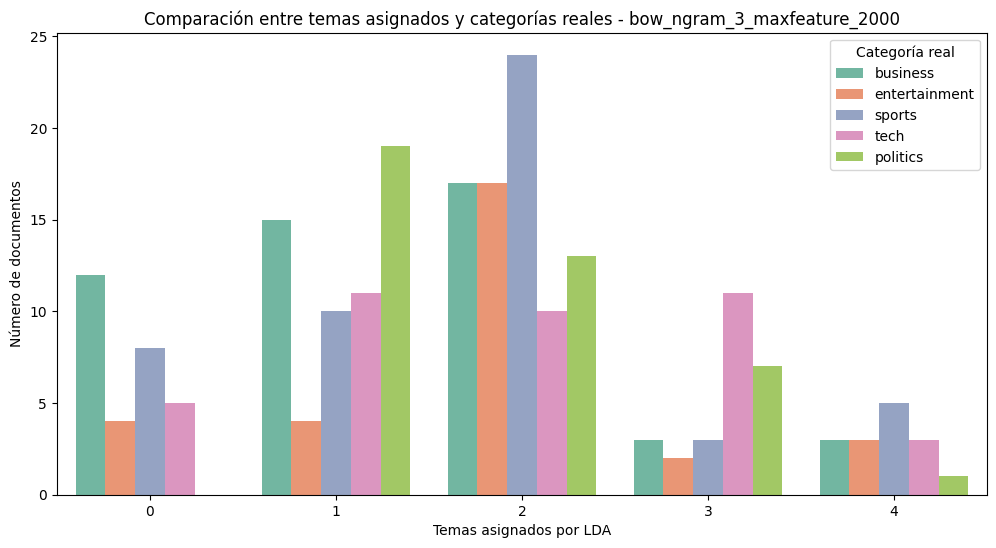

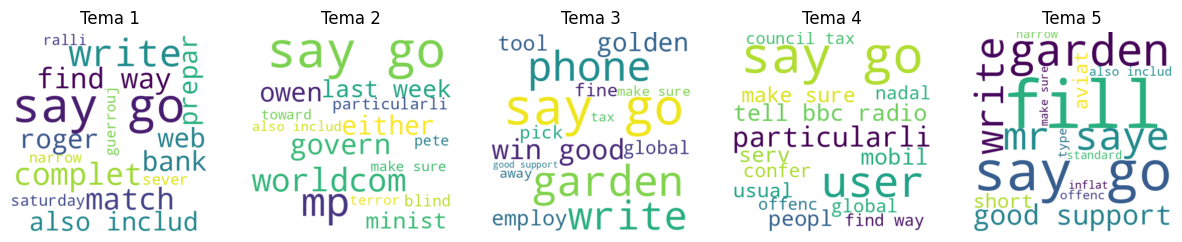



Graphics tfidf_ngram_1_maxfeature_500




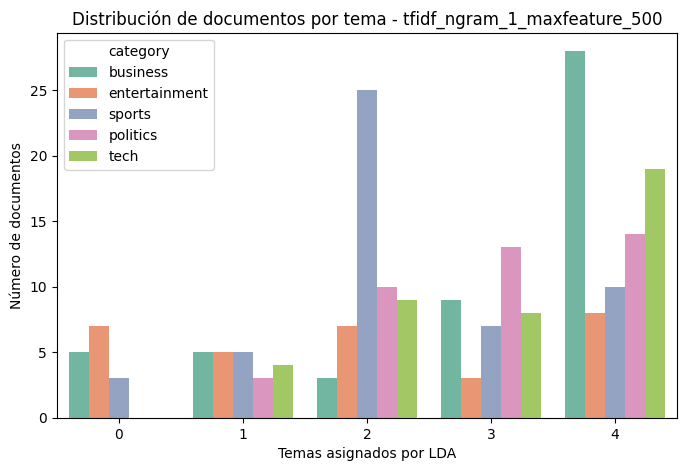

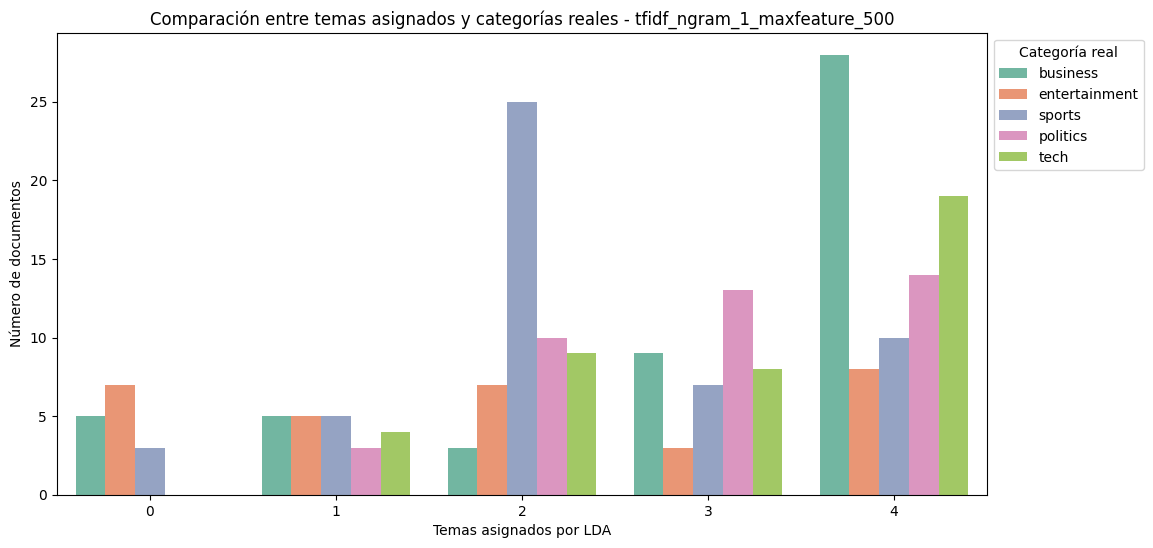

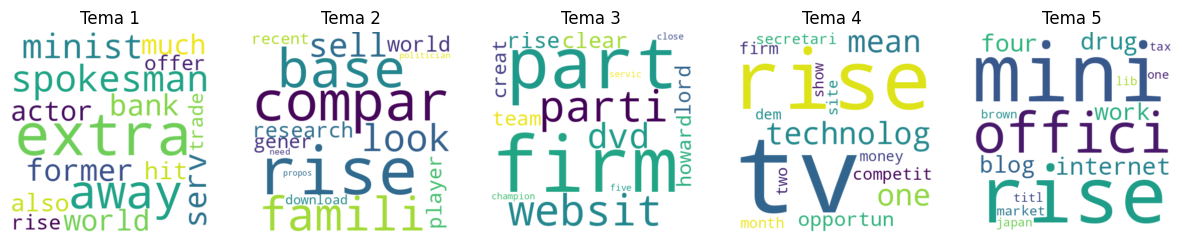



Graphics tfidf_ngram_2_maxfeature_500




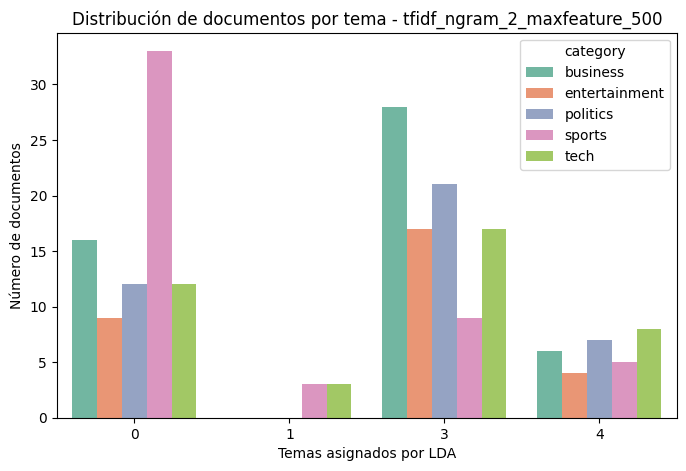

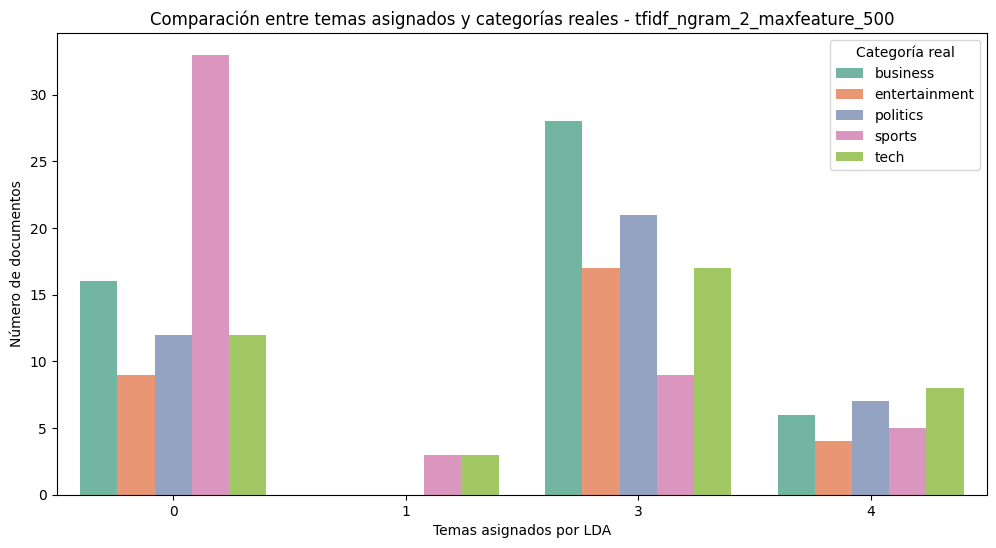

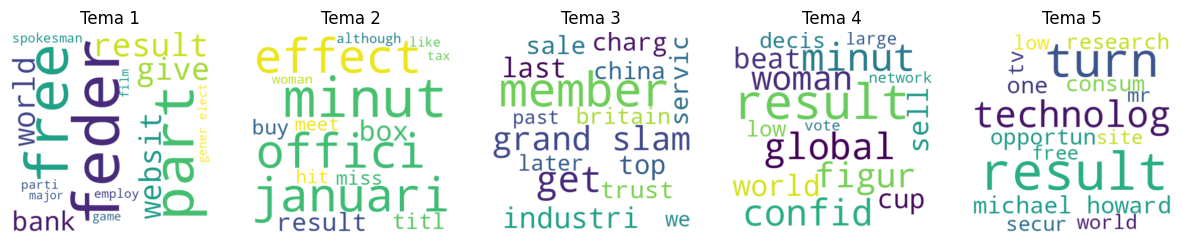



Graphics tfidf_ngram_3_maxfeature_500




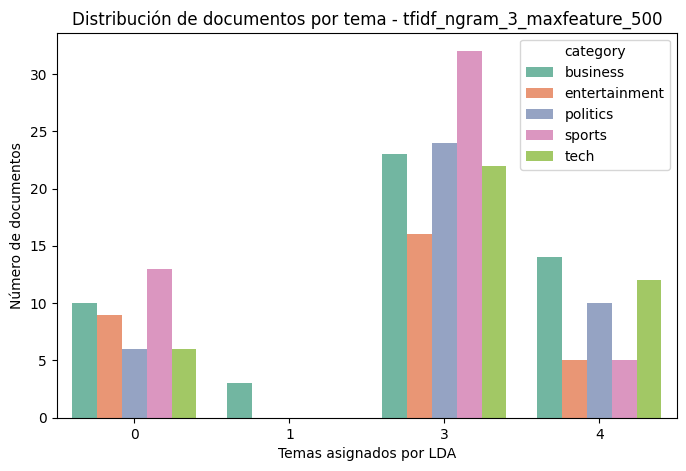

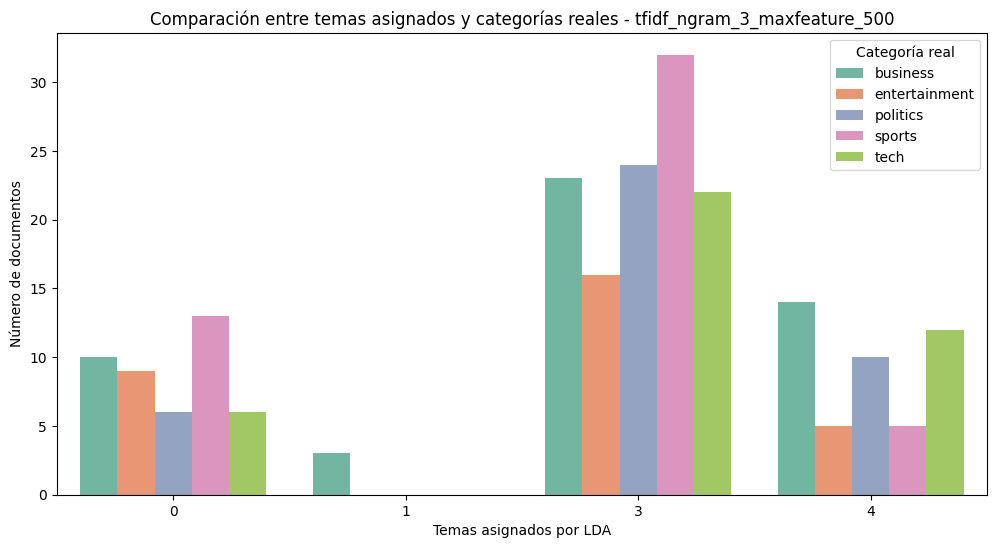

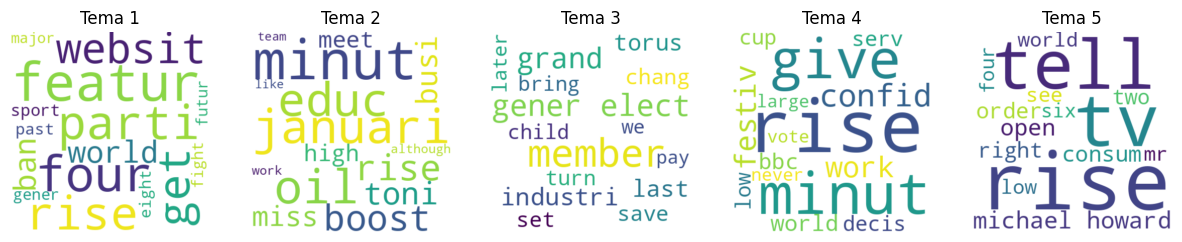



Graphics tfidf_ngram_1_maxfeature_1000




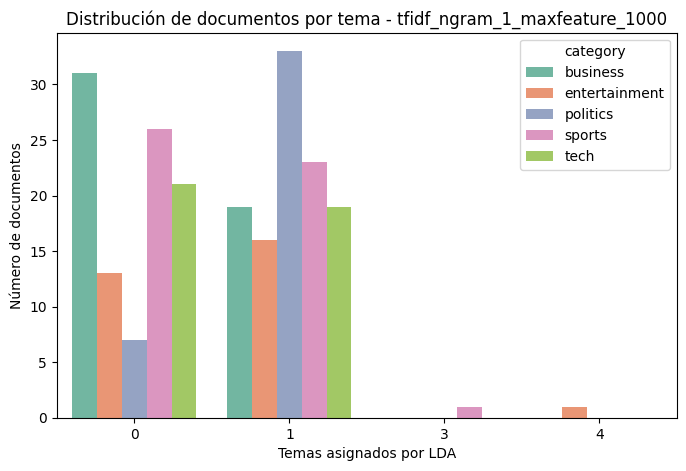

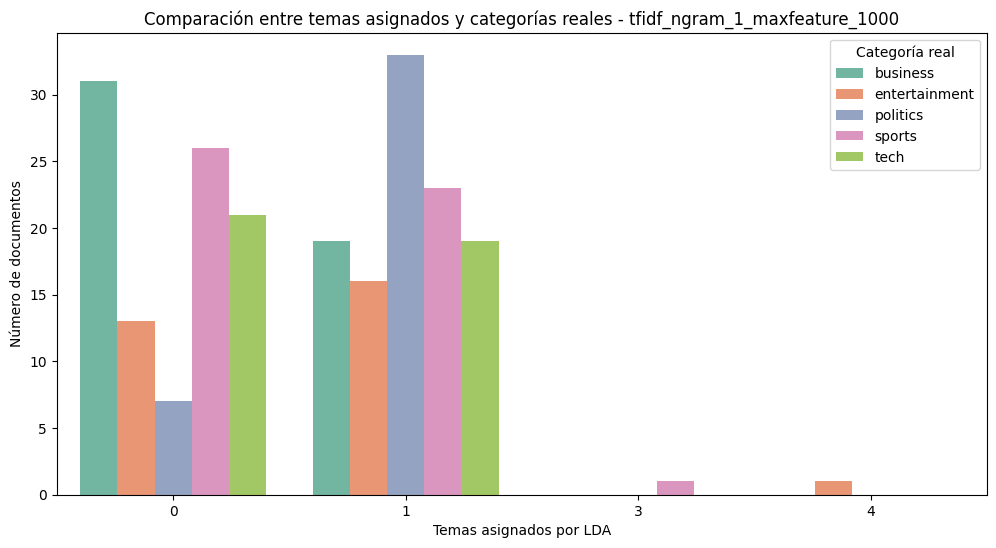

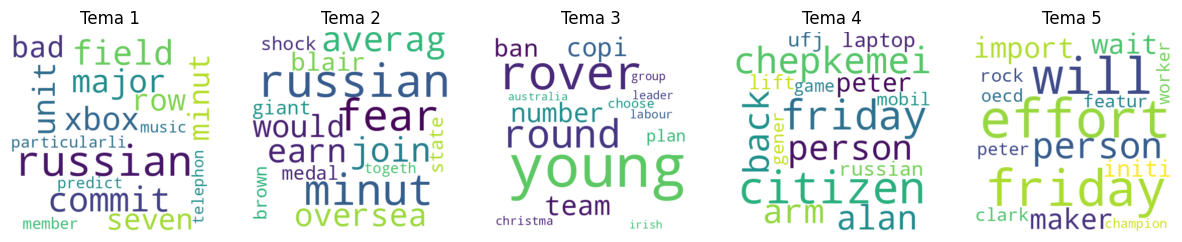



Graphics tfidf_ngram_2_maxfeature_1000




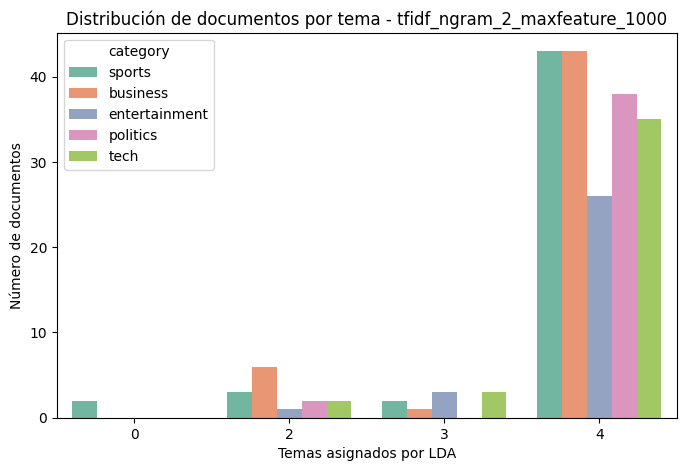

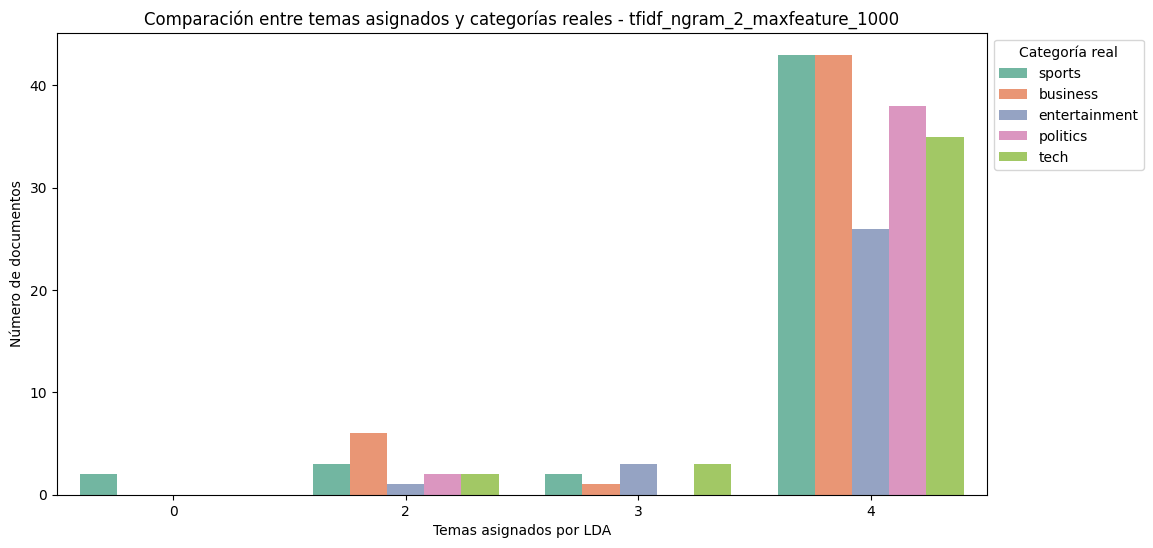

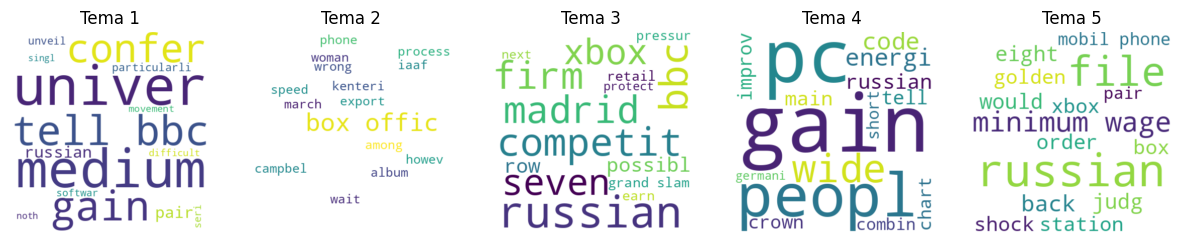



Graphics tfidf_ngram_3_maxfeature_1000




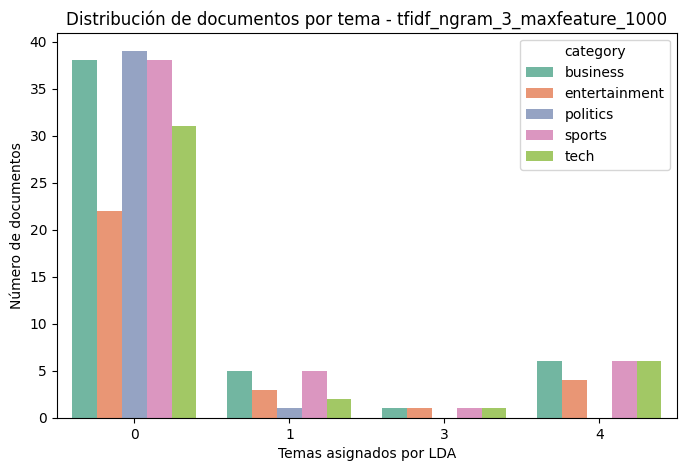

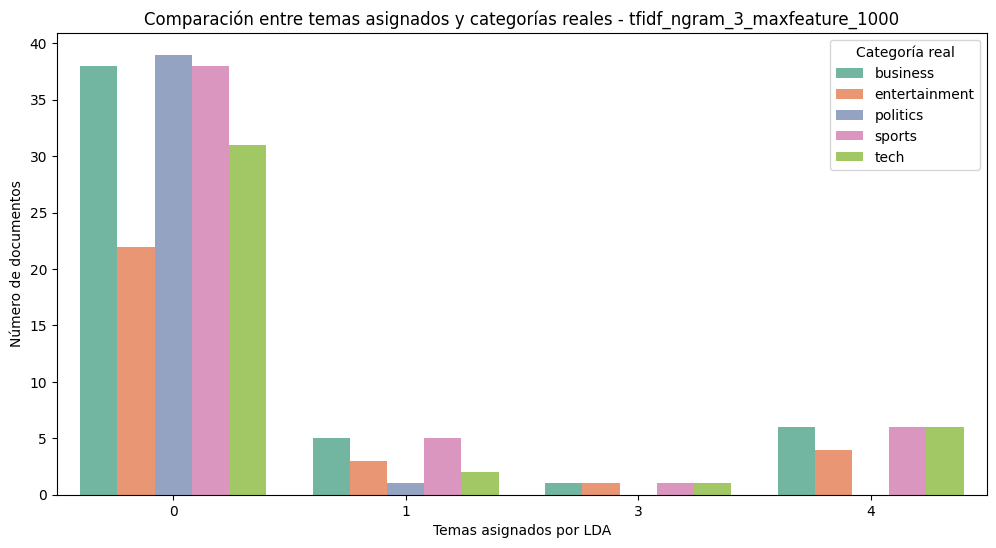

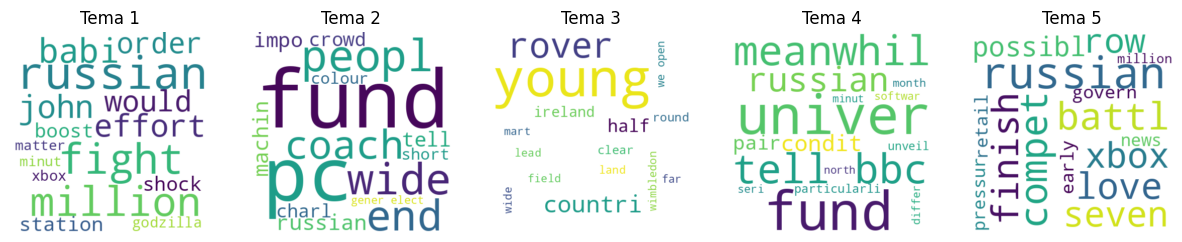



Graphics tfidf_ngram_1_maxfeature_1500




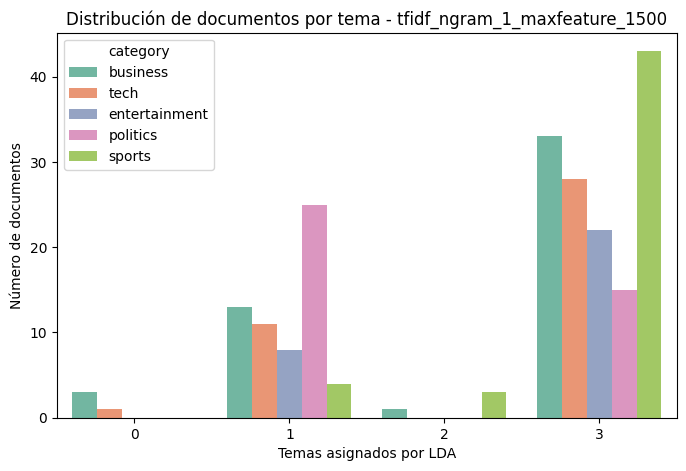

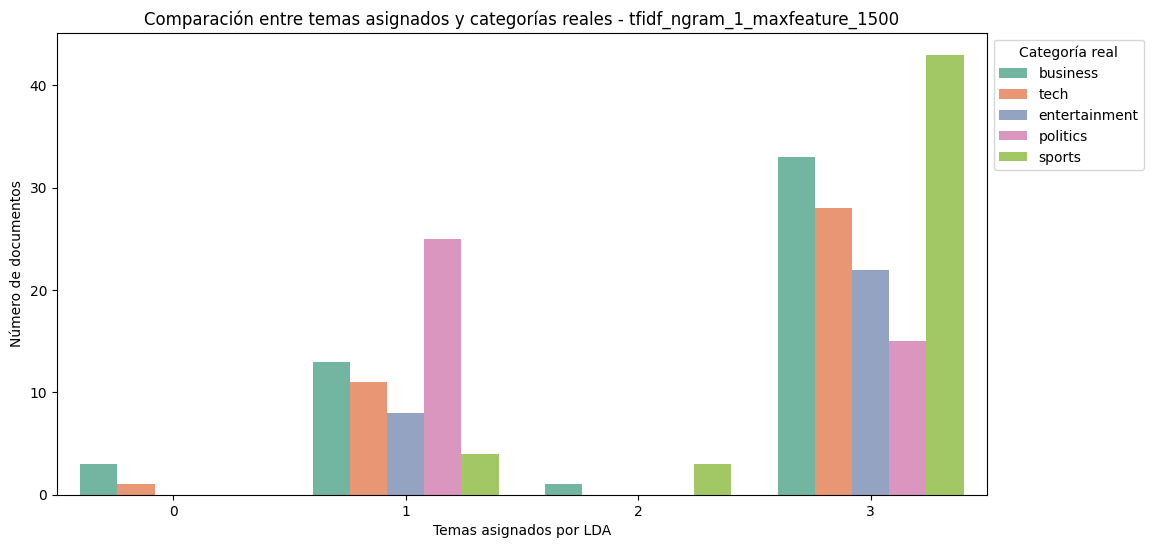

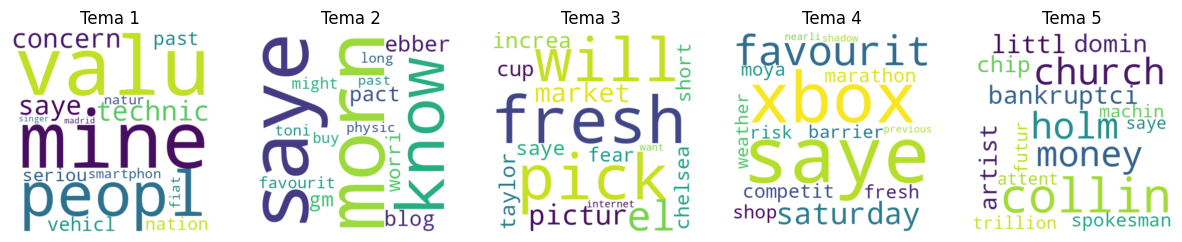



Graphics tfidf_ngram_2_maxfeature_1500




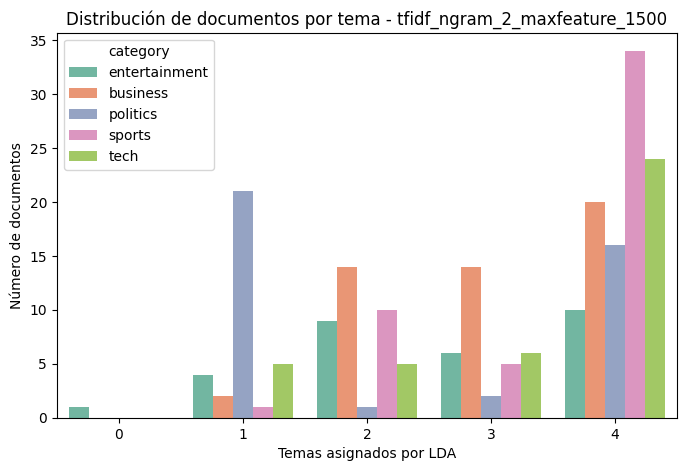

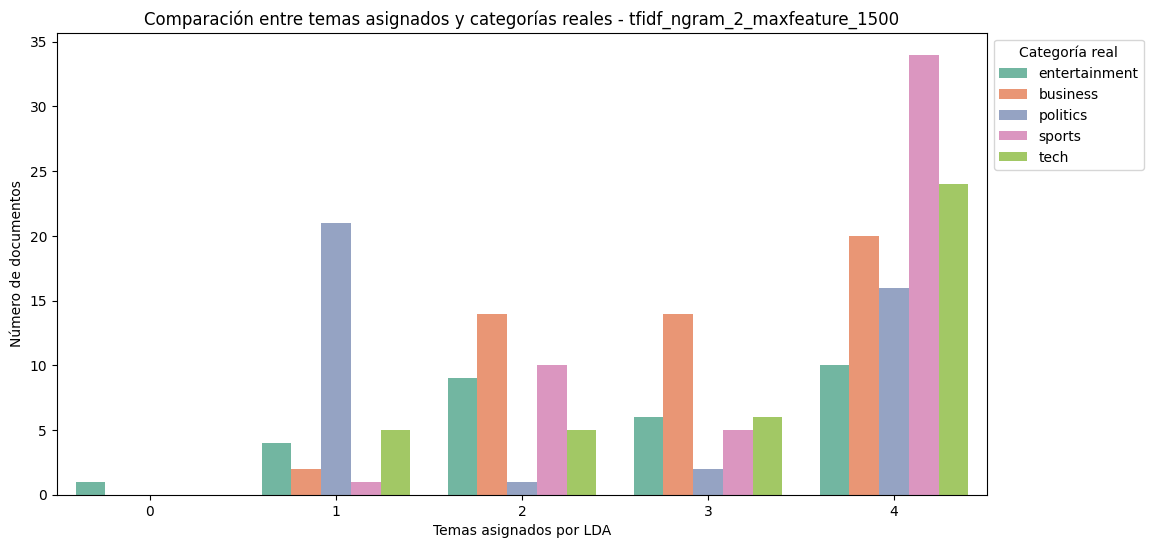

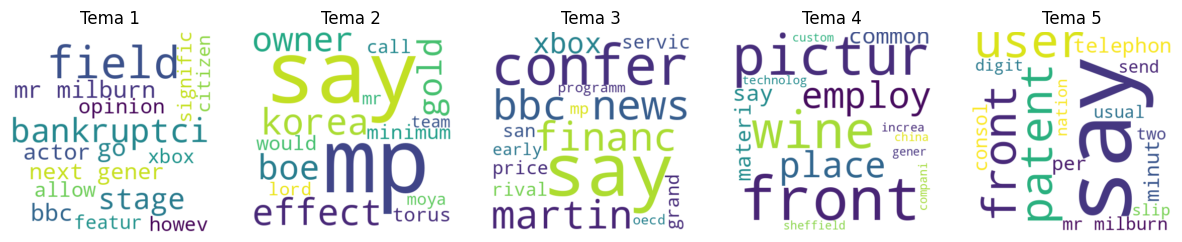



Graphics tfidf_ngram_3_maxfeature_1500




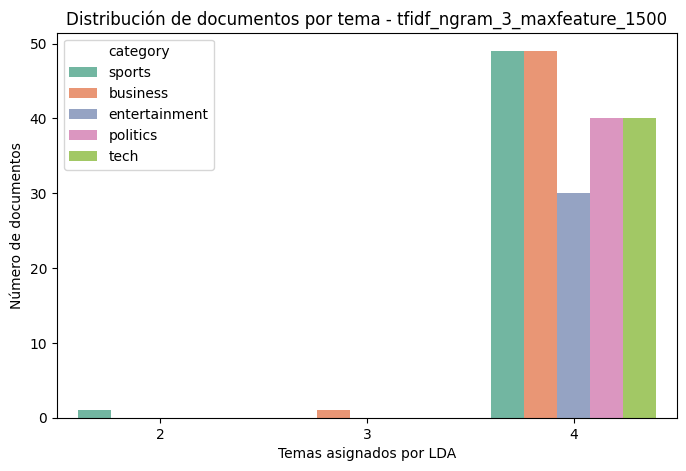

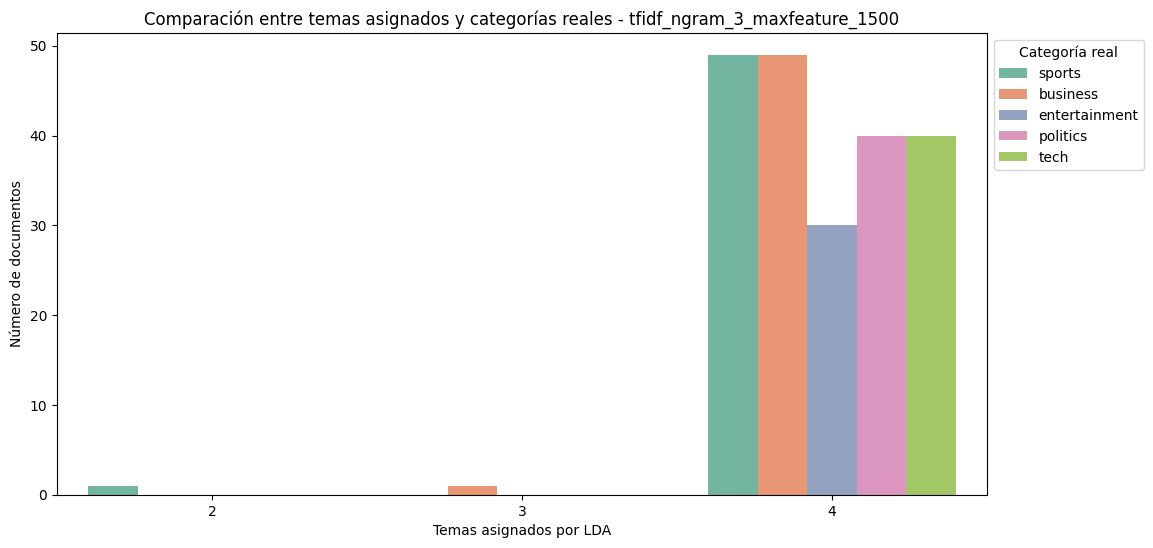

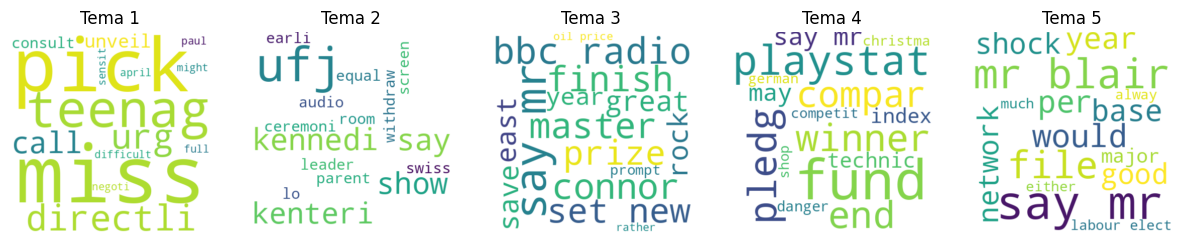



Graphics tfidf_ngram_1_maxfeature_2000




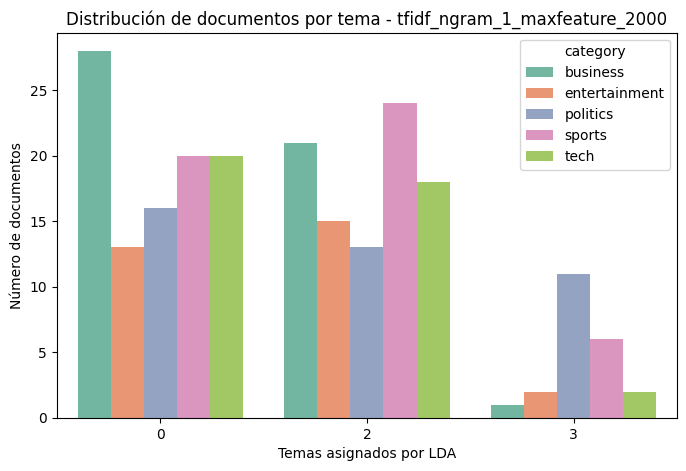

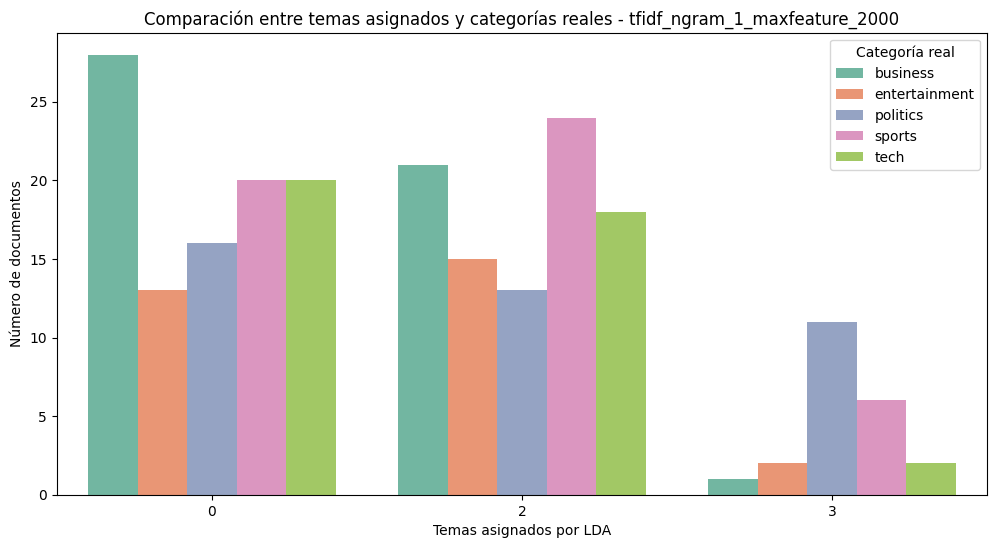

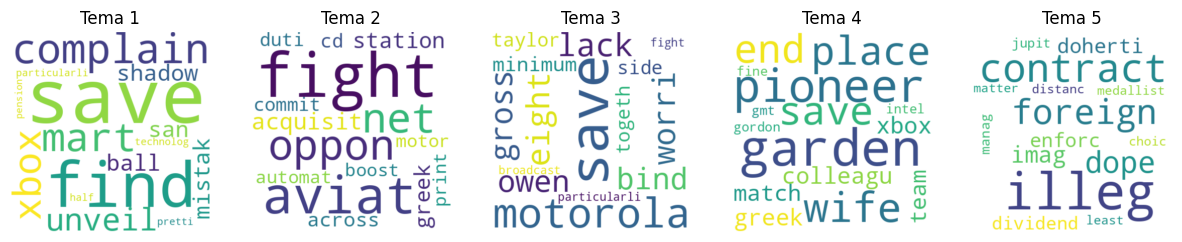



Graphics tfidf_ngram_2_maxfeature_2000




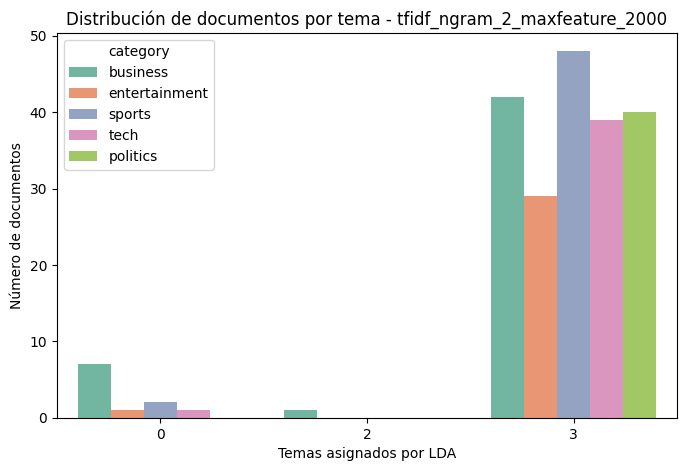

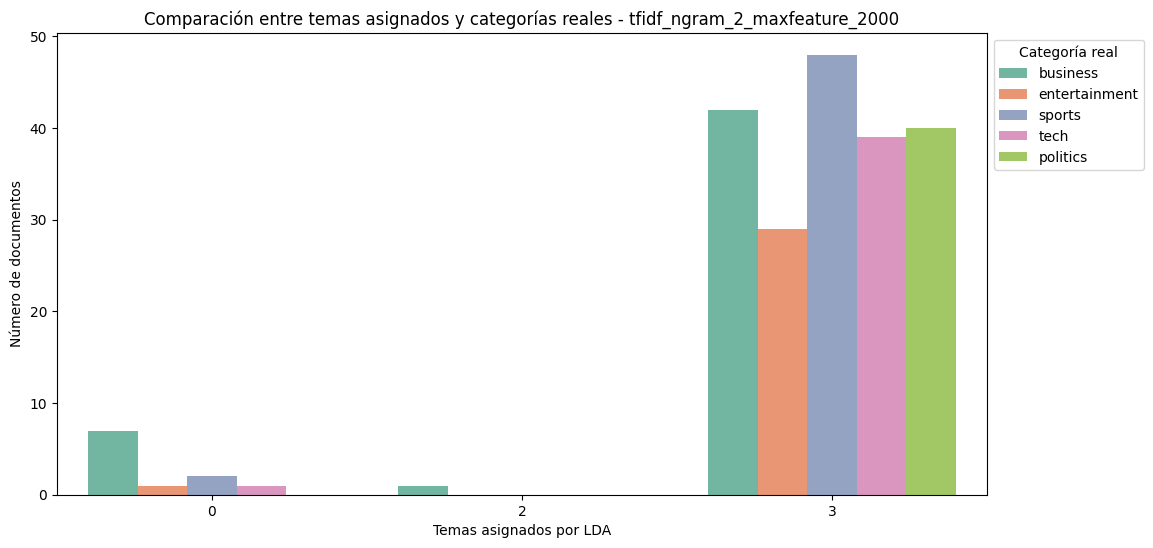

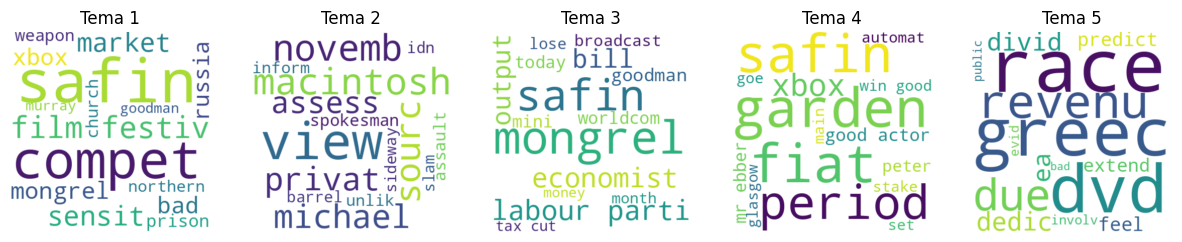



Graphics tfidf_ngram_3_maxfeature_2000




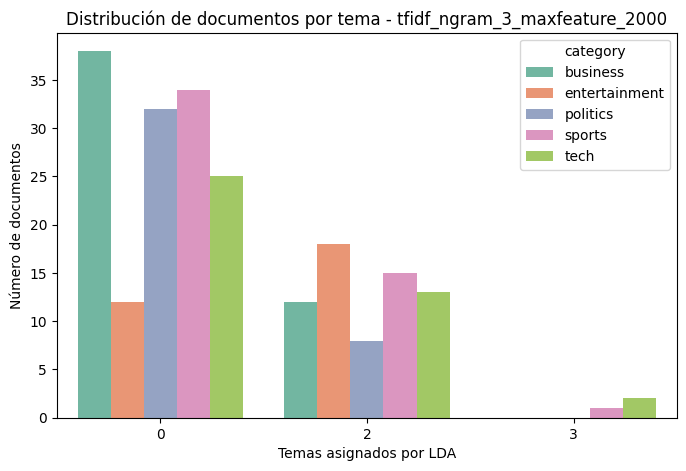

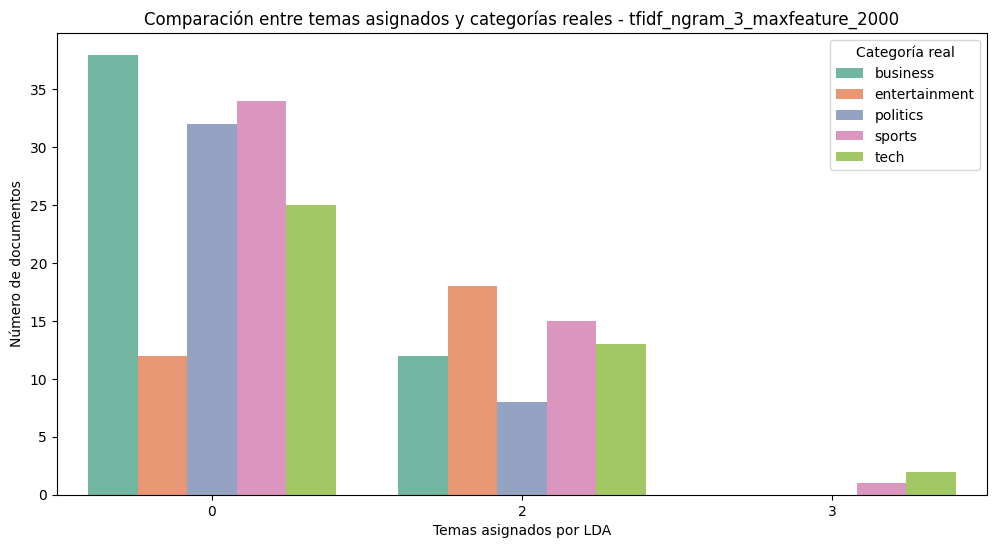

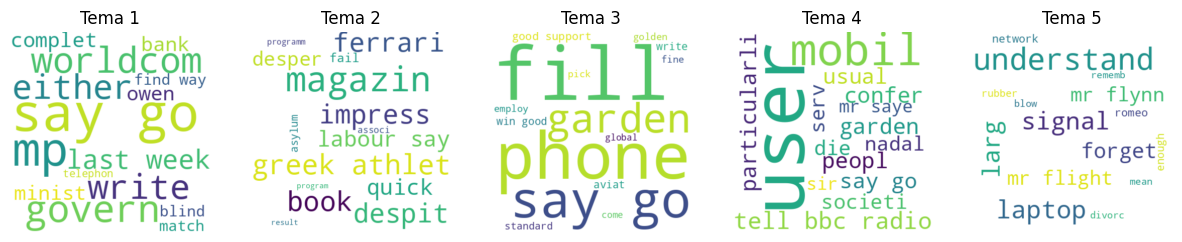

In [62]:
# Evaluación en conjunto de prueba (df_test)
df_test["processed_text"] = df_test["processed"].apply(lambda x: " ".join(x))  # Unimos tokens en texto

for rep in representations:
  for max_feature in max_features:
    for ngram_range in n_gram_ranges:
      key = f"{rep}_ngram_{ngram_range[1]}_maxfeature_{max_feature}"
      vectorizer, _ = represent_text(df_test, method=rep, ngram_range=ngram_range, max_features=max_feature)
      X_test = vectorizer.transform(df_test["processed_text"])  # Usamos el vectorizador entrenado
      doc_topic_distributions_test = models[key]["model"].transform(X_test)
      df_test["assigned_topic"] = np.argmax(doc_topic_distributions_test, axis=1)
      print(f'\n==================\n\nGraphics {key}\n\n==================\n')
      plot_topic_distribution(df_test, key)
      plot_category_vs_topic(df_test, key)

      # Promediar la distribución de tópicos para todo el conjunto de prueba
      feature_names = vectorizer.get_feature_names_out()
      topic_weights = np.mean(doc_topic_distributions_test, axis=0)

      plot_wordclouds(models[key]["model"], feature_names, num_topics=5)

In [63]:
import pickle

with open("lda_models.pkl", "wb") as f:
    pickle.dump(models, f)

# Almacenamiento de datos

In [ ]:
df_train.to_csv('data/results/training_dataset.csv')
df_test.to_csv('data/results/testing_dataset.csv')